# Research Title : "Influences on Melbourne Rent Prices: distance to Landmarks, Crime Records, and Land Use"

## 1.Topic

## 2.Research Question: How proximity to landmarks (such as universities,hospitals,stations), crime rates and land use patterns affect rental prices in different areas of Melbourne

## 3.Scope
Data from the Greater Melbourne area in 2021

##  4.Data sources

1. Census Data: Sourced from the "Census 2021 table G02 Victoria.gpkg," this dataset includes rental prices, median weekly rent, and other socio-economic indicators for the Melbourne area. 
Source: https://www.abs.gov.au/census/find-census-data/geopackages?release=2021&geography=VIC&topic=HIHC&gda=GDA2020

2. GIS Data: Derived from the "Greater Melbourne (ABS) study area.shp," this dataset defines the geographical boundaries of the Greater Melbourne study area. 
Source: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

3. Landmark Data: Obtained via the OpenStreetMap API, this dataset includes geographical location data for universities, hospitals, and train stations. 
Source: https://www.openstreetmap.org/relation/4246124#map=11/-37.7870/145.0140

4. Crime Data: Extracted from "Data_Tables_LGA_Criminal_Incidents_Year_Ending_December_2023.xlsx," this dataset contains records of criminal incidents by postcode for the year 2021.
Source: https://www.crimestatistics.vic.gov.au/crime-statistics/latest-victorian-crime-data/download-data

5. Land Use Raster Data: Provided by the "55H_20210101-20220101.tif" and "55H_20210101-20220101_clipped.tif," these datasets offer information on land cover types within the study area. Source: https://livingatlas.arcgis.com/landcoverexplorer/#mapCenter=39.18600%2C9.04200%2C10&mode=step&timeExtent=2017%2C2022&year=2020&downloadMode=true

## 5.Introduction

Understanding the determinants of rental prices in urban areas is an important area for urban planning, property investment and socio-economic policy formulation. This study focuses on exploring how adjacent landmarks (such as universities, hospitals and stations), crime rates and land use patterns affect rental prices in different areas of Melbourne. By analysing these factors, our aim is to reveal the underlying drivers of rental values in Melbourne.

The study utilised a variety of data sources for the year 2021, including census data, Geographic Information System (GIS) data and open source spatial datasets. These data sources provide an overview of socio-economic and environmental attributes that may affect rent prices.Specifically, point data provide geographical coordinates of landmarks such as universities, hospitals, and train stations; polygon data include census areas and their socio-economic indicators; and raster data offer information on land cover types within the study area. Additionally, crime data recorded by postcode is used to analyze the impact of safety on rental prices.

The analysis is divided into several key scenarios:

1. Landmarks: Investigating the relationship between rental prices and proximity to universities, hospitals, and train stations. This includes correlation analysis and spatial autocorrelation methods, such as Moran's I index and Local Indicators of Spatial Association (LISA), to understand spatial patterns and dependencies.
2. Land Use: Analyzing how different land cover types affect rental prices. This involves both unweighted and weighted overlay analyses, regression analysis using dummy variables, and K-means clustering to categorize land cover types and their associated rents.
3. Crime: Examining the impact of crime rates on rental prices. This includes merging crime data with rental data, calculating correlation coefficients, and conducting spatial analysis to understand the spatial distribution and impact of crime on rents.


Each scenario uses specific methodologies and statistical techniques to derive insights from the data, which will provide valuable information for professionals such as urban planners and policy makers. In summary, this study aims to provide a detailed understanding of factors influencing rental prices in Melbourne. Through integrated spatial and statistical analyses, the study provides a comprehensive view of the city's rental market, which emphasises the complex interactions between socio-economic factors and land use patterns.

### 5.1 literature review

In the introduction of our study, we have drawn upon a diverse array of seminal literature to deepen our understanding of the dynamics within the real estate market, focusing particularly on the influences of environmental and social factors. Ogur’s (1973) research on the impact of higher educational institutions on local rental markets is pivotal, demonstrating how the presence of colleges and universities can elevate nearby rental prices. This forms a fundamental part of our investigation into the influence of landmarks on housing costs.

Further examination of landmark effects includes the work by Zhang (2020), which utilizes the GWR model to assess the impact of various urban factors on Beijing's rental market. This study is crucial for our spatial econometric modeling, helping us understand how proximity to essential services like hospitals and train stations affects rent levels.

Additionally, Buonanno et al. (2013) explore the relationship between crime perceptions and housing prices, offering insights into how safety and public perception influence housing market dynamics. Alonso’s (1964) seminal work on location and land use also provides foundational theories on land rent, which are crucial for understanding the spatial distribution of housing costs in urban areas.

## 6.Methodology

### 6.1 Necessary package

In [1]:
from esda.moran import Moran, Moran_Local
from libpysal.weights import KNN, Queen
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from shapely.geometry import Point, MultiPoint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster
from spreg import ML_Lag
import geopandas as gpd
import json
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm
import warnings

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import rasterio.mask

import matplotlib.colors as mcolors
from rasterio.features import shapes

import statsmodels.formula.api as smf

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from shapely.geometry import shape
from shapely.geometry import Point

### 6.2 Loading data

#### 6.2.1 Prepare the Point data and Polygon data

In [2]:
# Read the shapefile for the Greater Melbourne study area and convert to the target CRS
census_polygons = gpd.read_file('data/Census 2021 table G02 Victoria.gpkg').to_crs(epsg=7855)
greater_melbourne_study_area = gpd.read_file('data/Greater Melbourne (ABS) study area.shp').to_crs(epsg=7855)

file_path = 'data/Data_Tables_LGA_Criminal_Incidents_Year_Ending_December_2023.xlsx'
table_03_df = pd.read_excel(file_path, sheet_name='Table 03')
table_03_df = table_03_df[table_03_df['Year'] == 2021]

def calculate_centroid(nodes, node_dict):
    points = [Point(node_dict[node]['lon'], node_dict[node]['lat']) for node in nodes if node in node_dict]
    if points:
        multi_point = MultiPoint(points)
        centroid = multi_point.centroid
        return centroid.x, centroid.y
    else:
        return None, None  
    
url = 'http://overpass-api.de/api/interpreter'
query = """
[out:json][timeout:50];
area(3604246124)->.melbourne;  // Use the correct OSM region ID
(
  node(area.melbourne)["amenity"="university"];
  way(area.melbourne)["amenity"="university"];
  relation(area.melbourne)["amenity"="university"];
  node(area.melbourne)["amenity"="hospital"];
  way(area.melbourne)["amenity"="hospital"];
  relation(area.melbourne)["amenity"="hospital"];
  node(area.melbourne)["railway"="station"];
  way(area.melbourne)["railway"="station"];
  relation(area.melbourne)["railway"="station"];
);
out body;
>;
out skel qt;
"""
response = requests.get(url, params={'data': query})
data = response.json()

node_dict = {node['id']: node for node in data['elements'] if node['type'] == 'node'}

landmarks = []

for element in data['elements']:
    if 'tags' in element and 'name' in element['tags'] and ('amenity' in element['tags'] or 'railway' in element['tags']):
        name = element['tags']['name']
        type = element['tags'].get('amenity', element['tags'].get('railway', 'Type not specified'))
        if element['type'] == 'node' and 'lat' in element and 'lon' in element:
            latitude, longitude = element['lat'], element['lon']
        elif element['type'] in ['way', 'relation'] and 'nodes' in element:
            longitude, latitude = calculate_centroid(element['nodes'], node_dict)
            if longitude is None or latitude is None:
                continue  
        else:
            continue  
        landmarks.append({"name": name, "type": type, "latitude": latitude, "longitude": longitude})

#### 6.2.2 Prepare the raster data

In [15]:
# Read tif file
src_file = 'data/55H_20210101-20220101.tif'
dst_file = 'data/55H_20210101-20220101_transformed.tif'

dst_crs = 'EPSG:7855'

with rasterio.open(src_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(dst_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

print("The transformation is complete and the file is saved in:", dst_file)


The transformation is complete and the file is saved in: data/55H_20210101-20220101_transformed.tif


### 6.3 Data Visualisation

#### 6.3.1 landmarks

In [16]:
counts = {}
for landmark in landmarks:
    counts[landmark["type"]] = counts.get(landmark["type"], 0) + 1

for key, value in counts.items():
    print(f"Total number of {key}: {value}")

Total number of station: 253
Total number of hospital: 130
Total number of university: 56


In [17]:
landmarks_data = {
    "name": [lm['name'] for lm in landmarks],
    "type": [lm['type'] for lm in landmarks],
    "geometry": [Point(lm['longitude'], lm['latitude']) for lm in landmarks]
}

landmarks_gdf = gpd.GeoDataFrame(landmarks_data, crs="EPSG:4326")
landmarks_gdf = landmarks_gdf.to_crs(epsg=7855)

##### 6.3.1.1 Choropleth Map

In [24]:
census_polygons_clipped = gpd.clip(census_polygons, greater_melbourne_study_area)

def plot_map(gdf, census_gdf, landmark_type, title, filename, color):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    census_gdf.plot(column='Median_rent_weekly', cmap='YlGnBu', edgecolor="k", linewidth=0.3, ax=ax, legend=True, cax=cax)
    
    gdf_filtered = gdf[gdf['type'] == landmark_type]
    gdf_filtered.plot(ax=ax, marker='o', color=color, markersize=50, alpha=0.8)  
    
    # Enhanced North Arrow
    x, y, arrow_length = 0.95, 0.95, 0.05
    ax.annotate('', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20, xycoords=ax.transAxes)
    
    # Refined Scale Bar
    scalebar = ScaleBar(1, location='lower left', scale_loc='bottom', units='m', dimension='si-length', length_fraction=0.1, height_fraction=0.02, color='gray', scale_formatter=lambda value, _: f'{int(value)} m')
    ax.add_artist(scalebar)

    ax.set_title(title, fontsize=15)
    cax.set_ylabel('Median Rent ($/week)', fontsize=12)
    
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

##### 6.3.1.1.1University point data

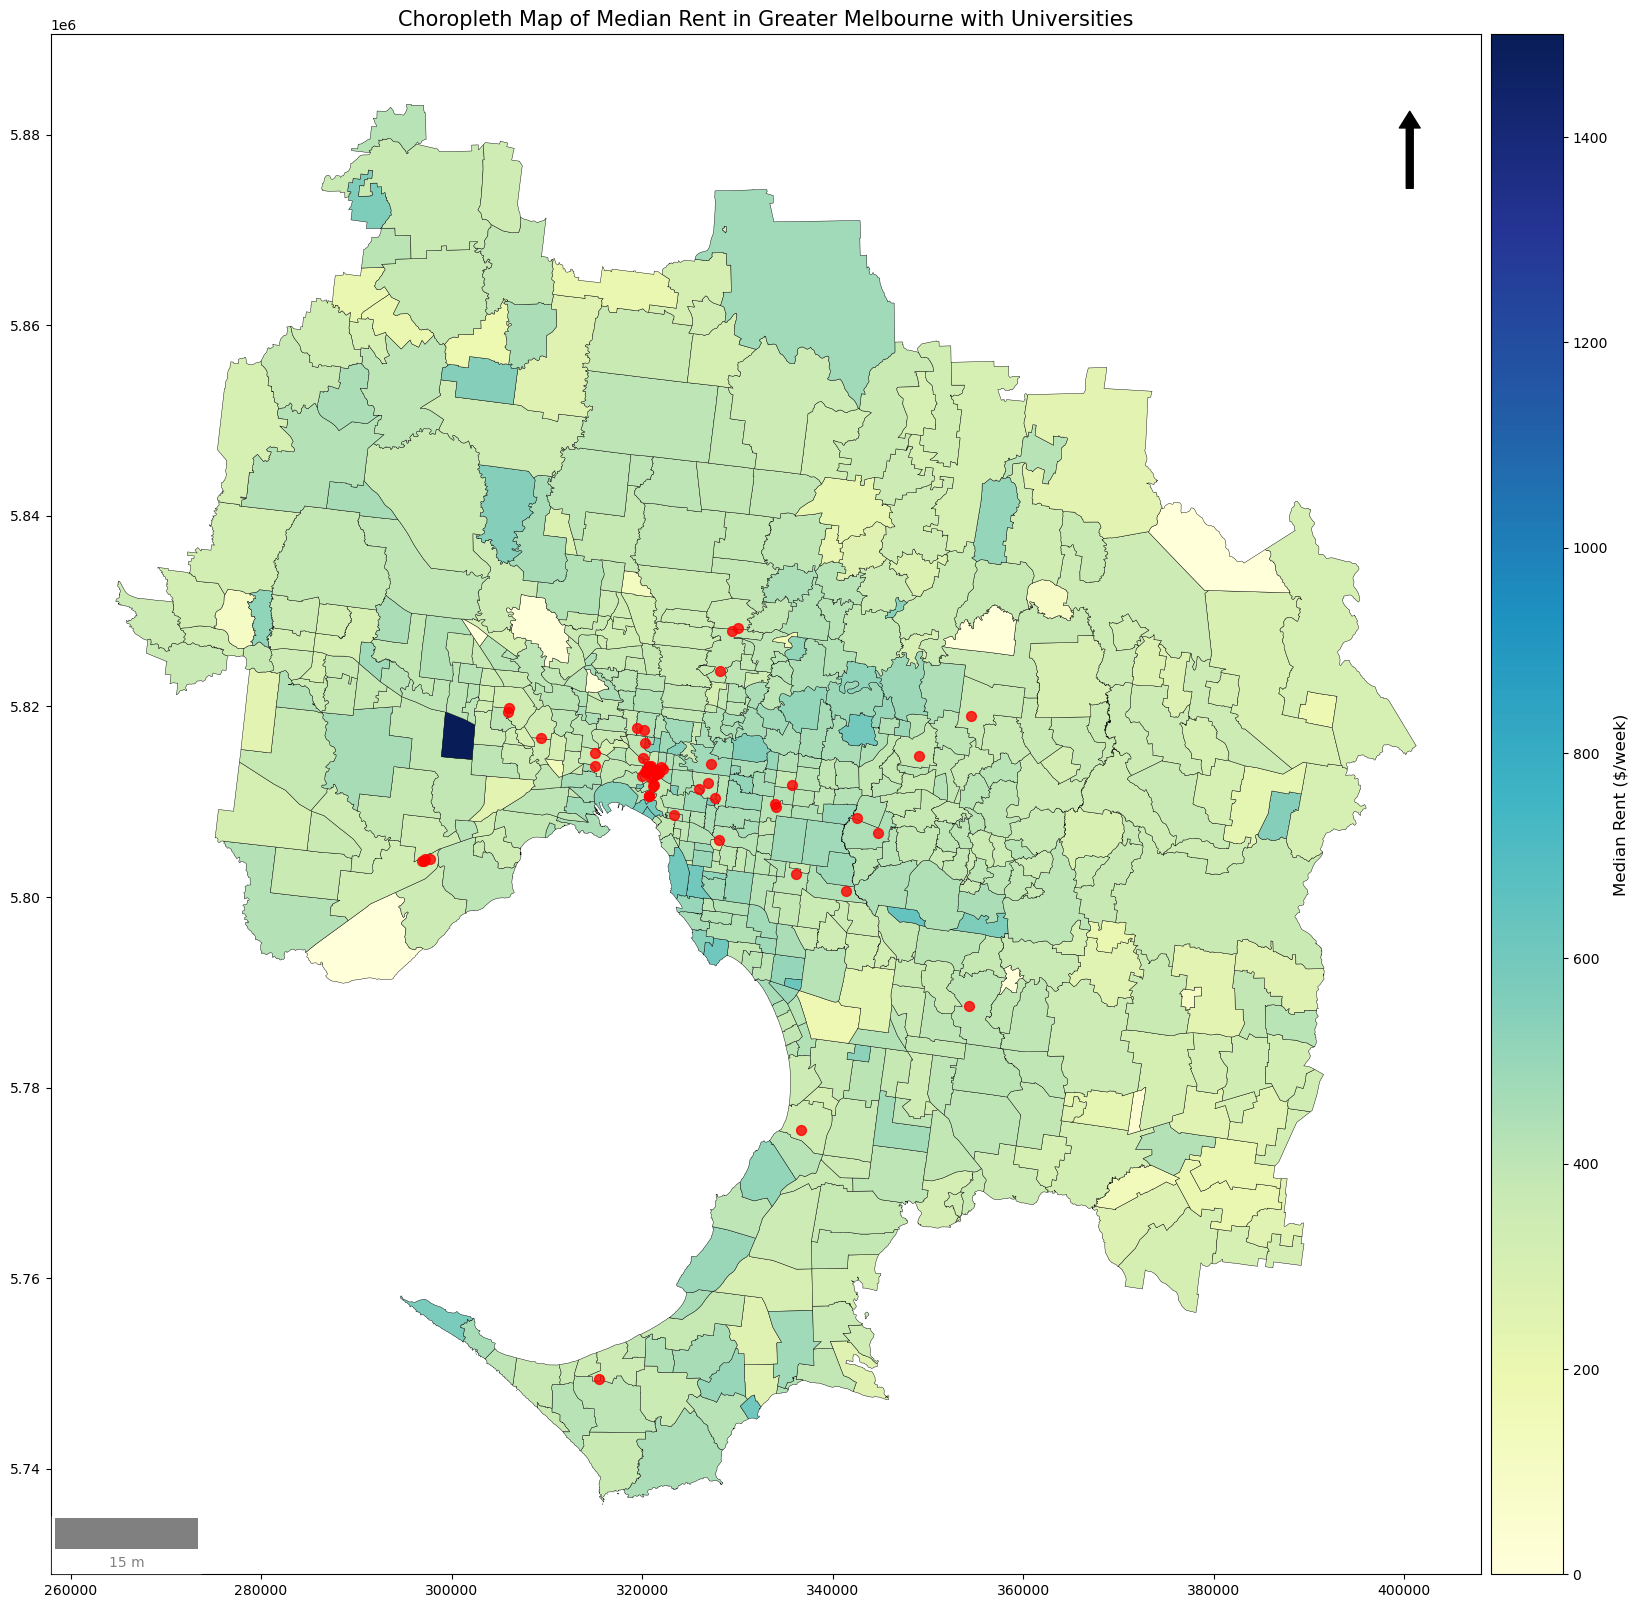

In [25]:
plot_map(landmarks_gdf, census_polygons_clipped, 'university', "Choropleth Map of Median Rent in Greater Melbourne with Universities", "universities_map.png", 'red')

**Landmark Distribution**: Red dots represent university locations, primarily concentrated in urban areas and certain suburbs, showing some level of clustering.

**Rent Distribution**: Similar to hospitals and stations, rents near universities are also moderately to highly priced, especially around city centers and major educational zones.

##### 6.3.1.1.2 Hospitals point data

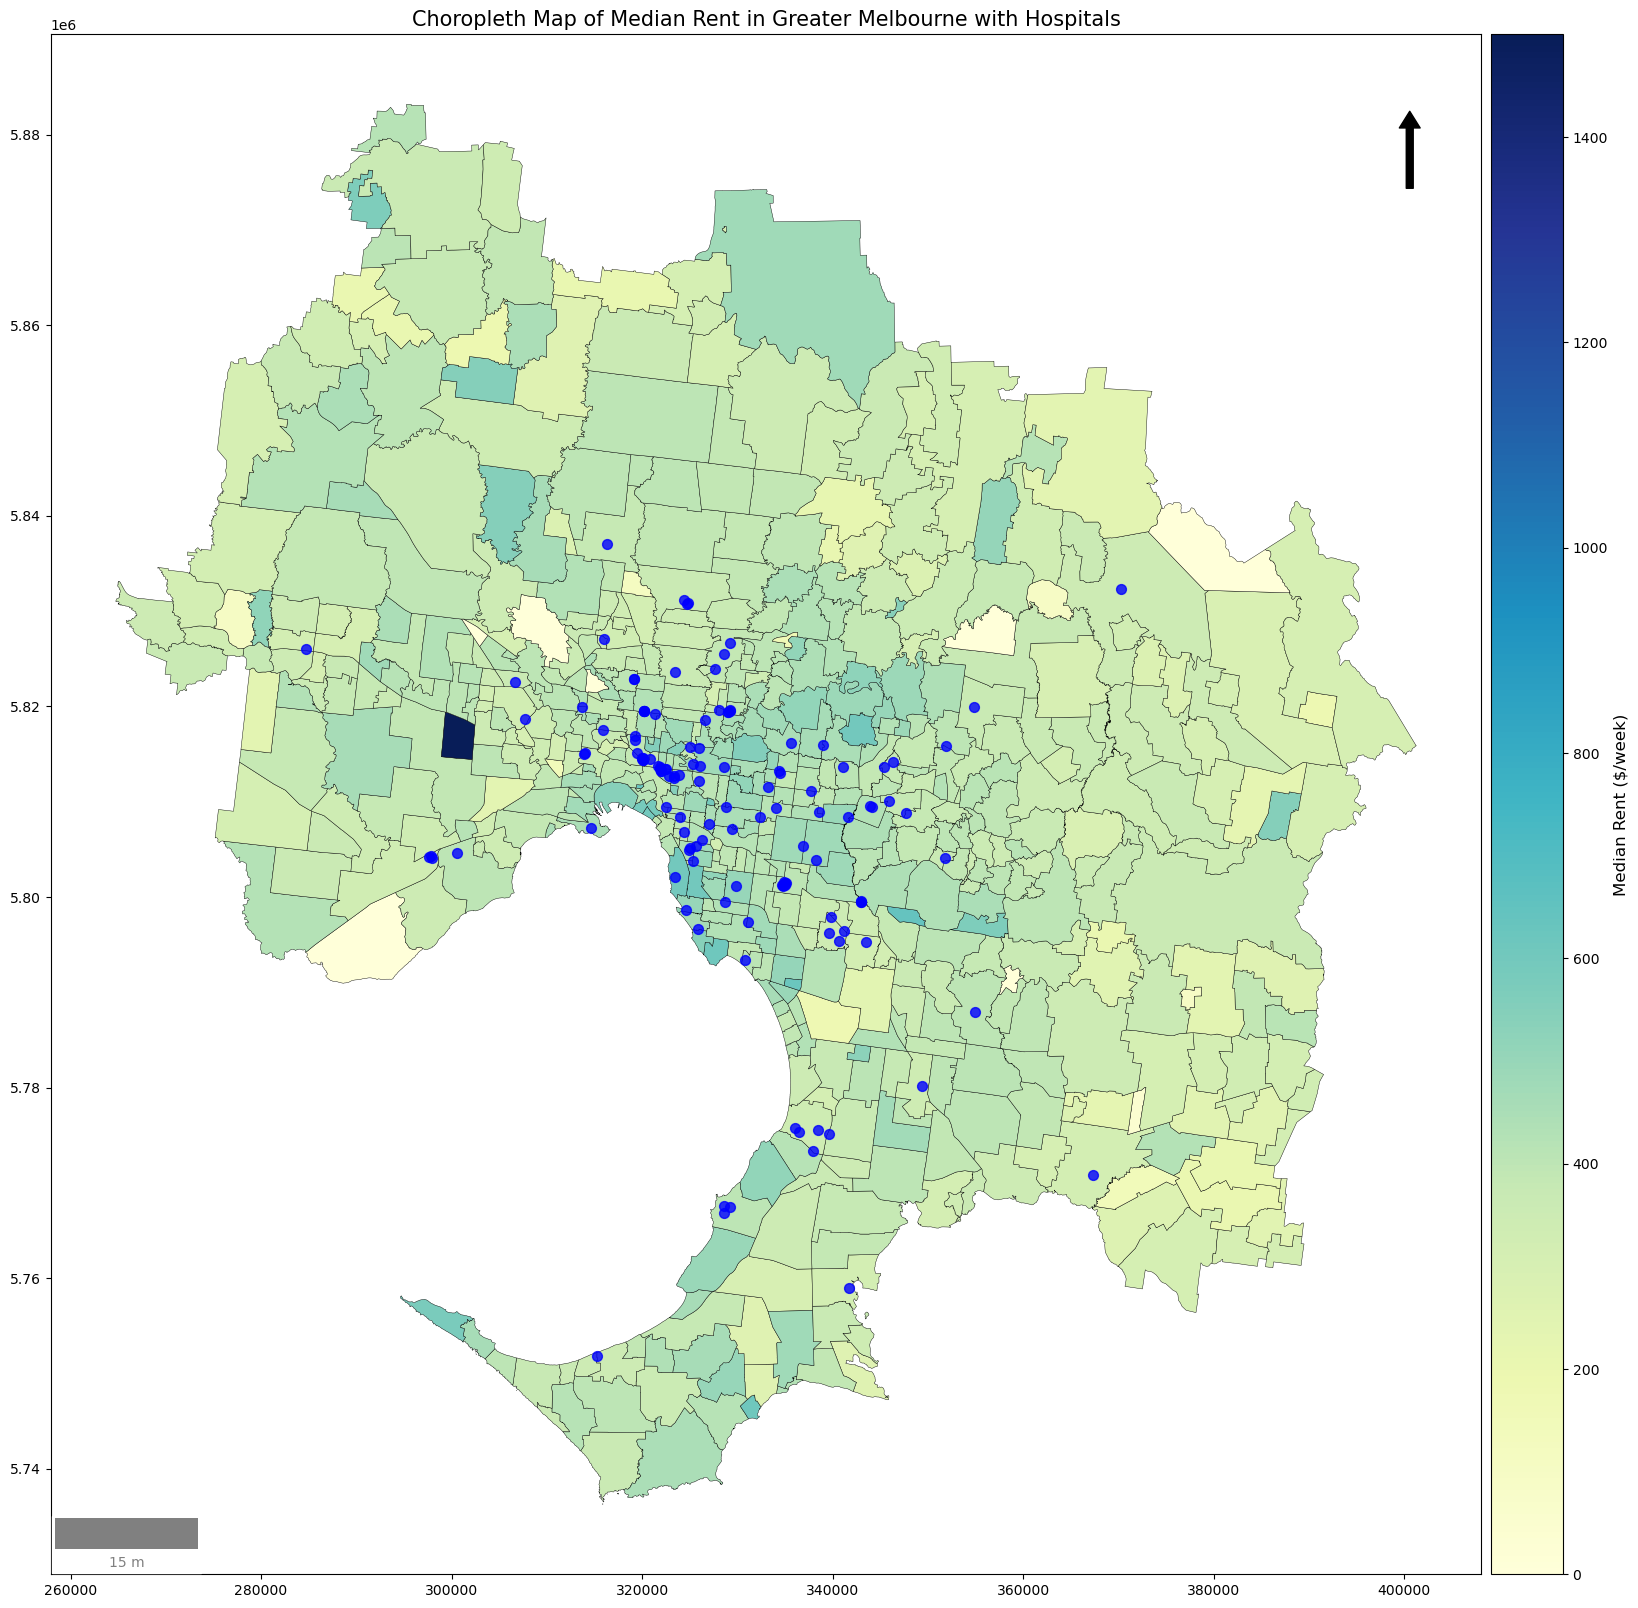

In [26]:
plot_map(landmarks_gdf, census_polygons_clipped, 'hospital', "Choropleth Map of Median Rent in Greater Melbourne with Hospitals", "hospitals_map.png", 'blue')

**Landmark Distribution**: The blue dots represent hospital locations, which are evenly distributed across the Greater Melbourne area.

**Rent Distribution**: The background colors indicate median weekly rents in different areas, ranging from dark blue (higher rents) to light green (lower rents). It is observable that some hospitals are located in higher rent areas (dark blue), especially around the city center and its surrounding areas.

##### 6.3.1.1.3 Station point data

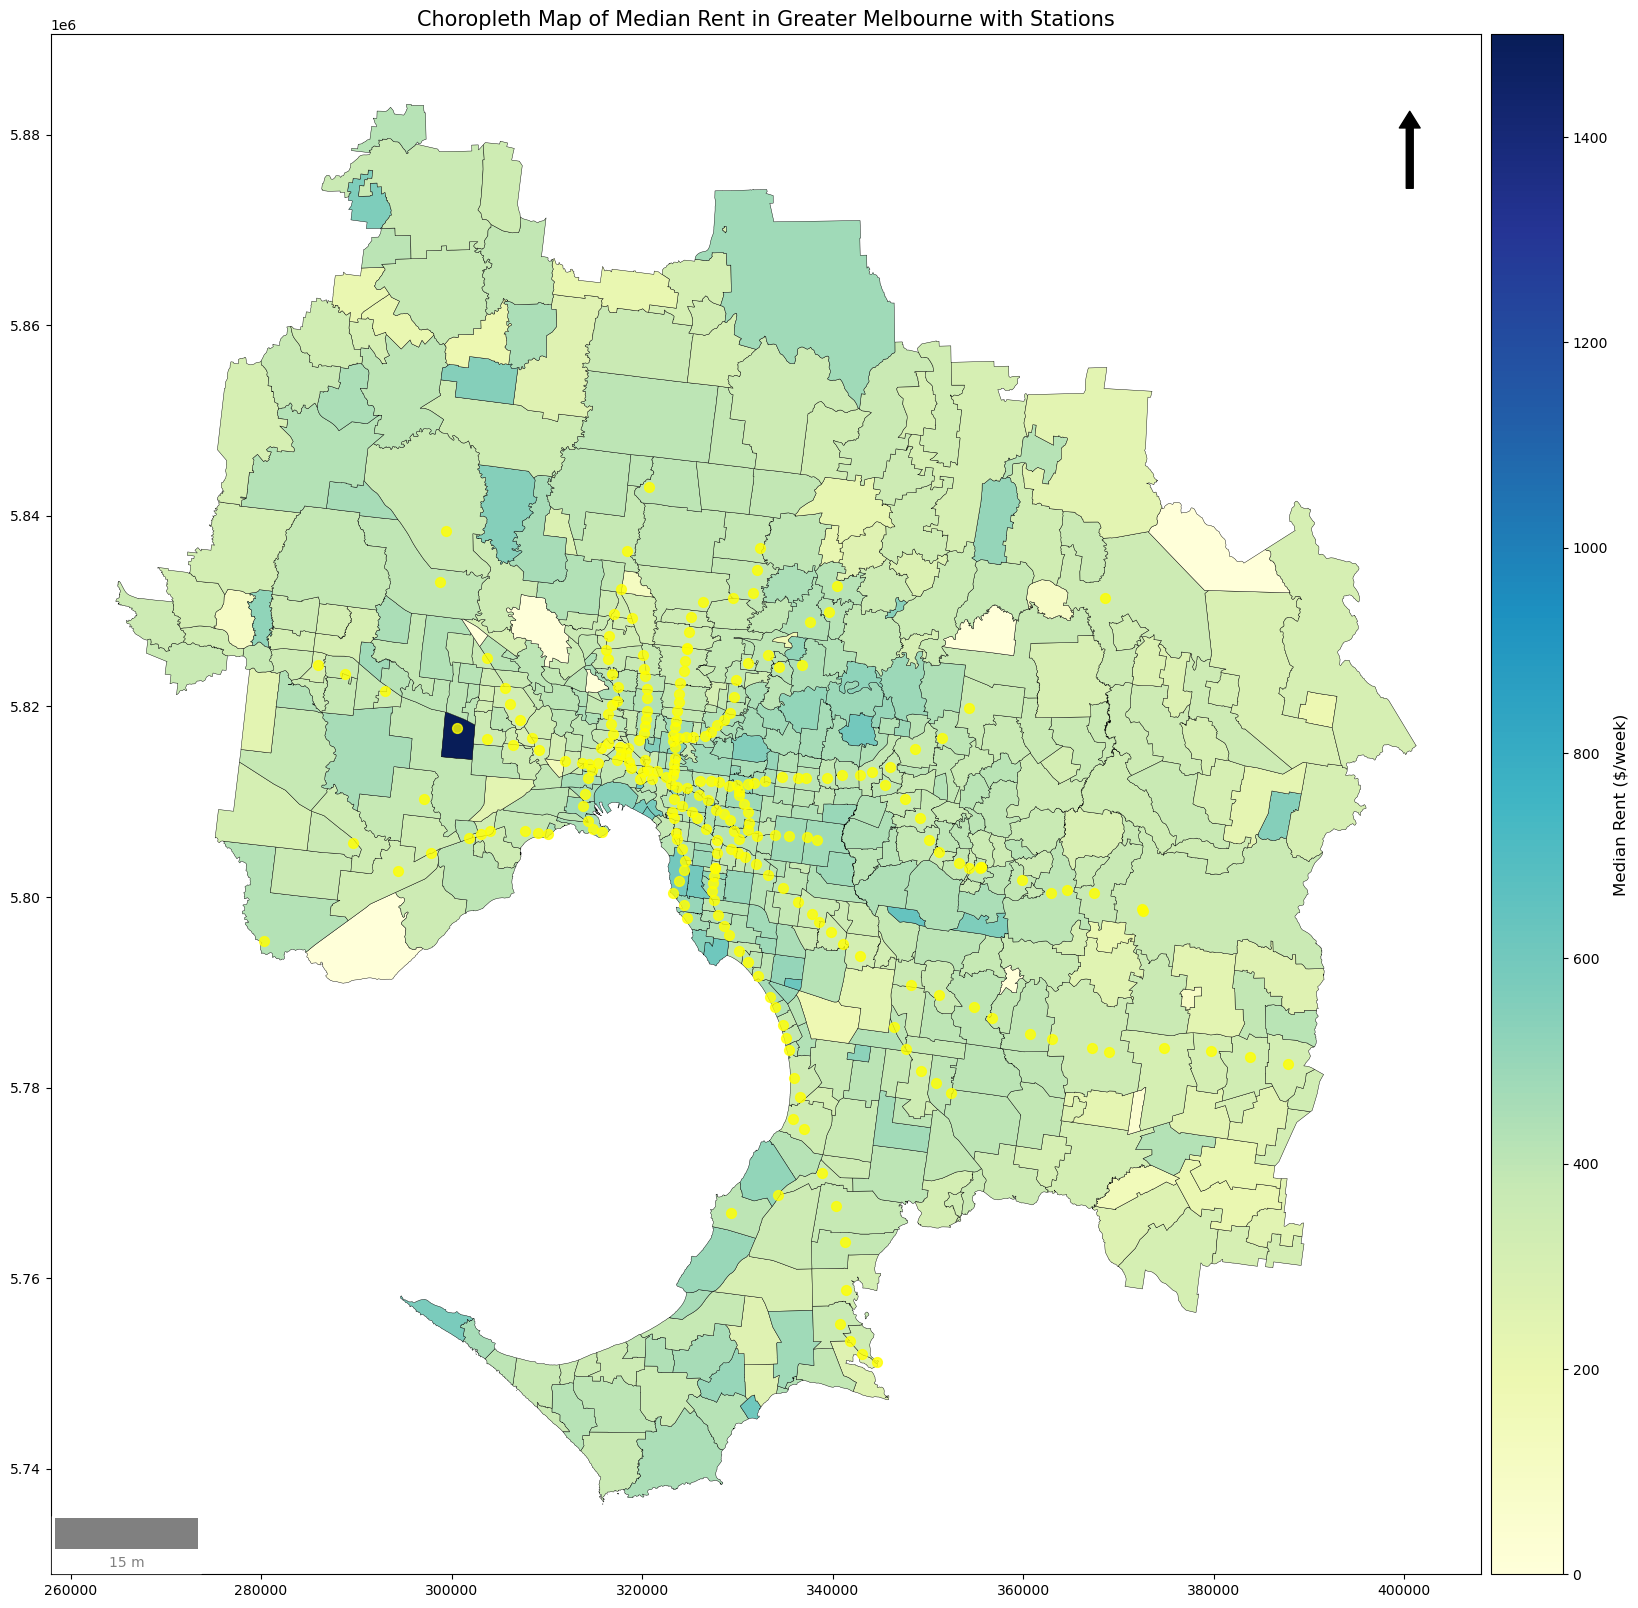

In [27]:
plot_map(landmarks_gdf, census_polygons_clipped, 'station', "Choropleth Map of Median Rent in Greater Melbourne with Stations", "stations_map.png", 'yellow')

**Landmark Distribution**: Yellow dots indicate station locations, concentrated in the city center and along major commuter lines.

**Rent Distribution**: The areas near stations generally exhibit higher rents, particularly in the city center. The map shows that rents tend to decrease moving from the center to the outskirts.

#### 6.3.2 Land use

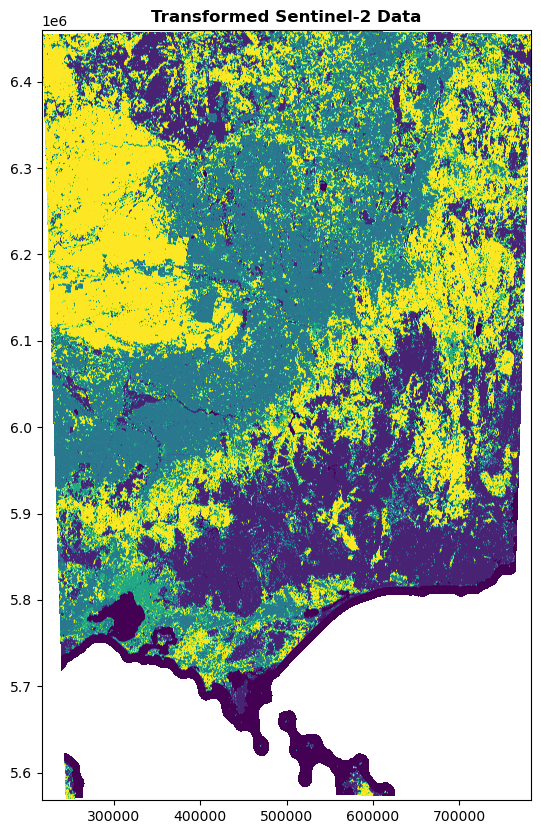

In [18]:
# Read tif
transformed_tif = 'data/55H_20210101-20220101_transformed.tif'

with rasterio.open(transformed_tif) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, title="Transformed Sentinel-2 Data")
    plt.show()


### Defining the scope of the study

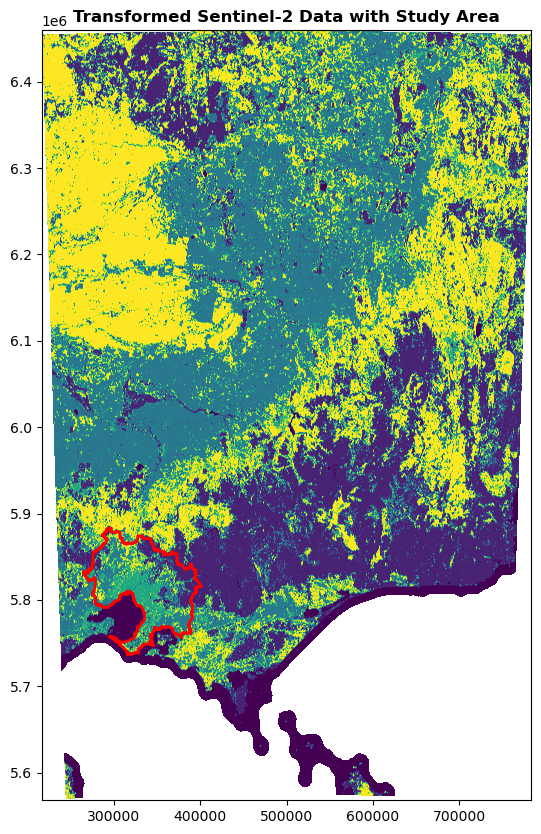

In [19]:
# Open file and show 
with rasterio.open(transformed_tif) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show raster data
    show(src, ax=ax, title="Transformed Sentinel-2 Data with Study Area")
    
    # Show study area
    greater_melbourne_study_area.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
    
    plt.show()

### Show the whole study area data

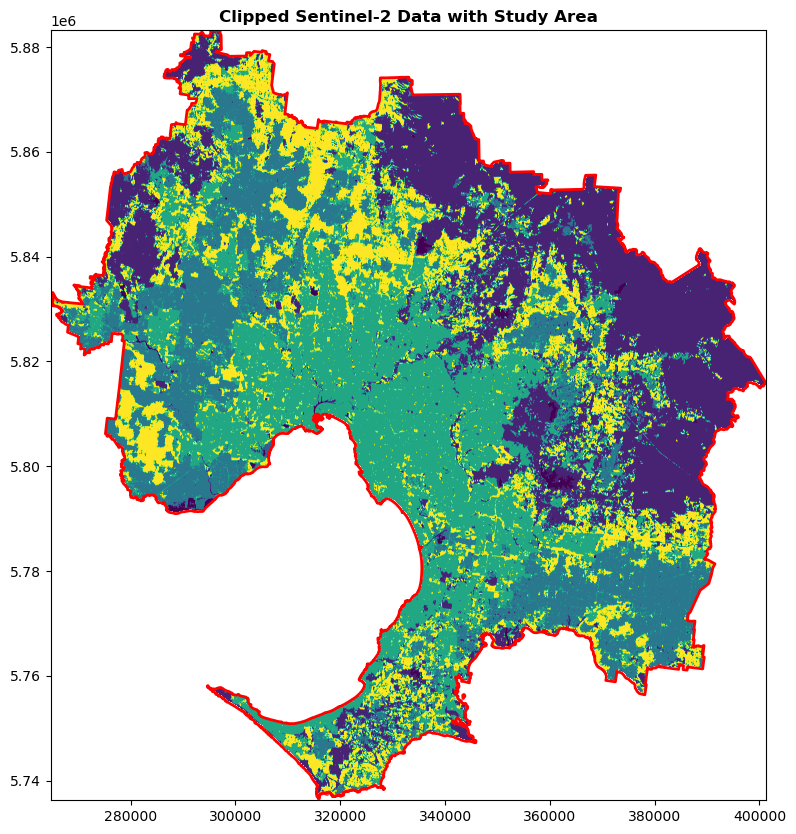

In [20]:
# Convert study area to GeoJSON
study_area_geojson = greater_melbourne_study_area.geometry

# Using rasterio to open and crop a file
with rasterio.open(transformed_tif) as src:
    out_image, out_transform = rasterio.mask.mask(src, study_area_geojson, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

# Save 
clipped_tif = 'data/55H_20210101-20220101_clipped.tif'
with rasterio.open(clipped_tif, 'w', **out_meta) as dest:
    dest.write(out_image)

# Read Clipped data
with rasterio.open(clipped_tif) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, title="Clipped Sentinel-2 Data with Study Area")
    greater_melbourne_study_area.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
    plt.show()

Basic information about the data:
Raster data shape (bands, height, width): (1, 14695, 13651)
Number of bands: 1
Coordinate Reference System (CRS): EPSG:7855
Geographic bounds: BoundingBox(left=264739.99999760796, bottom=5736260.000106749, right=401249.9999962847, top=5883210.000105325)
Pixel size (transform): | 10.00, 0.00, 264740.00|
| 0.00,-10.00, 5883210.00|
| 0.00, 0.00, 1.00|
Band statistics:
Min value: 0
Max value: 11
Mean value: 2.973468436381403
Standard deviation: 3.7901316885815612


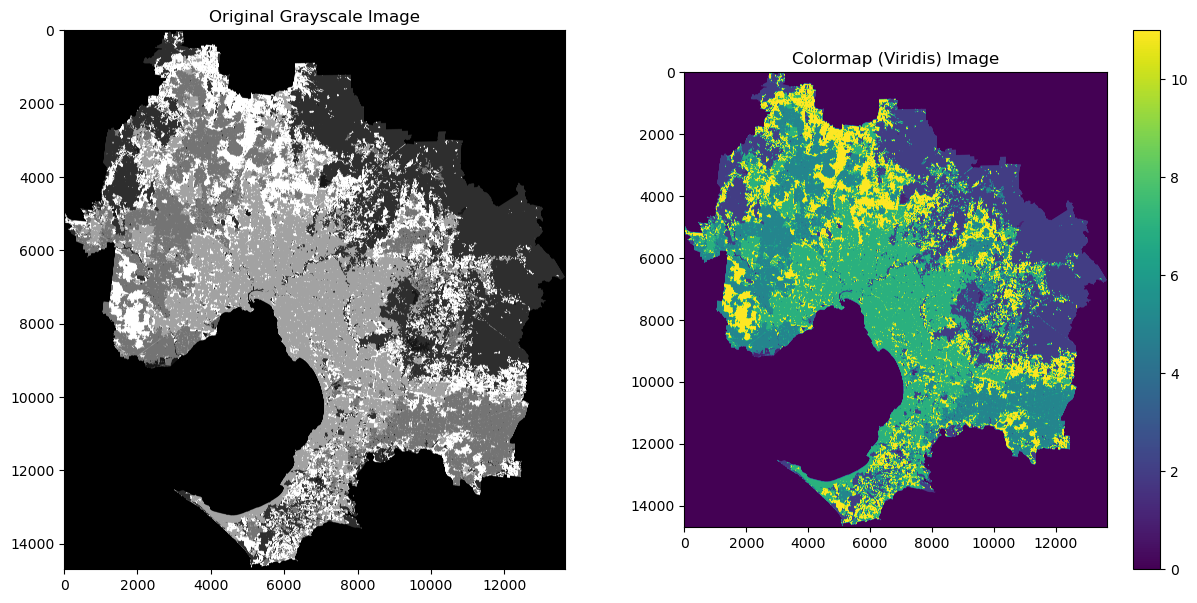

In [21]:
# Reading a cropped tif file
clipped_tif = 'data/55H_20210101-20220101_clipped.tif'

with rasterio.open(clipped_tif) as src:
    print("Basic information about the data:")
    print(f"Raster data shape (bands, height, width): {src.count, src.height, src.width}")
    print(f"Number of bands: {src.count}")
    print(f"Coordinate Reference System (CRS): {src.crs}")
    print(f"Geographic bounds: {src.bounds}")
    print(f"Pixel size (transform): {src.transform}")

    band = src.read(1)
    
    # View statistics on band values
    print("Band statistics:")
    print(f"Min value: {band.min()}")
    print(f"Max value: {band.max()}")
    print(f"Mean value: {band.mean()}")
    print(f"Standard deviation: {band.std()}")
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original grey scale image
    ax[0].imshow(band, cmap='gray')
    ax[0].set_title('Original Grayscale Image')
    
    # Colour Chart Display
    cax = ax[1].imshow(band, cmap='viridis')
    ax[1].set_title('Colormap (Viridis) Image')
    fig.colorbar(cax, ax=ax[1], orientation='vertical')
    
    plt.show()

### Land Cover Type Distribution in the Study Area

In [22]:
# Define the name of the land cover type
land_cover_names = {
    1: 'Water',
    2: 'Trees',
    4: 'Flooded Vegetation',
    5: 'Crops',
    7: 'Built Area',
    8: 'Bare Ground',
    9: 'Snow/Ice',
    10: 'Clouds',
    11: 'Rangeland'
}

# Reading a cropped tif file
clipped_tif = 'data/55H_20210101-20220101_clipped.tif'
with rasterio.open(clipped_tif) as src:
    band = src.read(1)
    
    # Checking for unique values
    unique_values = np.unique(band)
    print(f"Unique values in raster data: {unique_values}")
    
    # Get unique values and their frequency, excluding invalid values 0
    unique, counts = np.unique(band[band != 0], return_counts=True)
    
    # Creating a dataframe to display the results
    land_cover_stats = pd.DataFrame({'Land_Cover_Type': unique, 'Count': counts})
    
    # Add Land_Cover_Name column
    land_cover_stats['Land_Cover_Name'] = land_cover_stats['Land_Cover_Type'].map(land_cover_names)
    land_cover_stats['Percentage'] = (land_cover_stats['Count'] / land_cover_stats['Count'].sum()) * 100

print(land_cover_stats)


Unique values in raster data: [ 0  1  2  4  5  7  8 10 11]
   Land_Cover_Type     Count     Land_Cover_Name  Percentage
0                1    950781               Water    0.952113
1                2  28982657               Trees   29.023249
2                4    158195  Flooded Vegetation    0.158417
3                5  20287344               Crops   20.315758
4                7  27150995          Built Area   27.189022
5                8     62304         Bare Ground    0.062391
6               10      5409              Clouds    0.005417
7               11  22262453           Rangeland   22.293633


   Land_Cover_Type     Count     Land_Cover_Name  Percentage
0              1.0    950781               Water    0.952113
1              2.0  28982657               Trees   29.023249
2              4.0    158195  Flooded Vegetation    0.158417
3              5.0  20287344               Crops   20.315758
4              7.0  27150995          Built Area   27.189022
5              8.0     62304         Bare Ground    0.062391
6             10.0      5409              Clouds    0.005417
7             11.0  22262453           Rangeland   22.293633


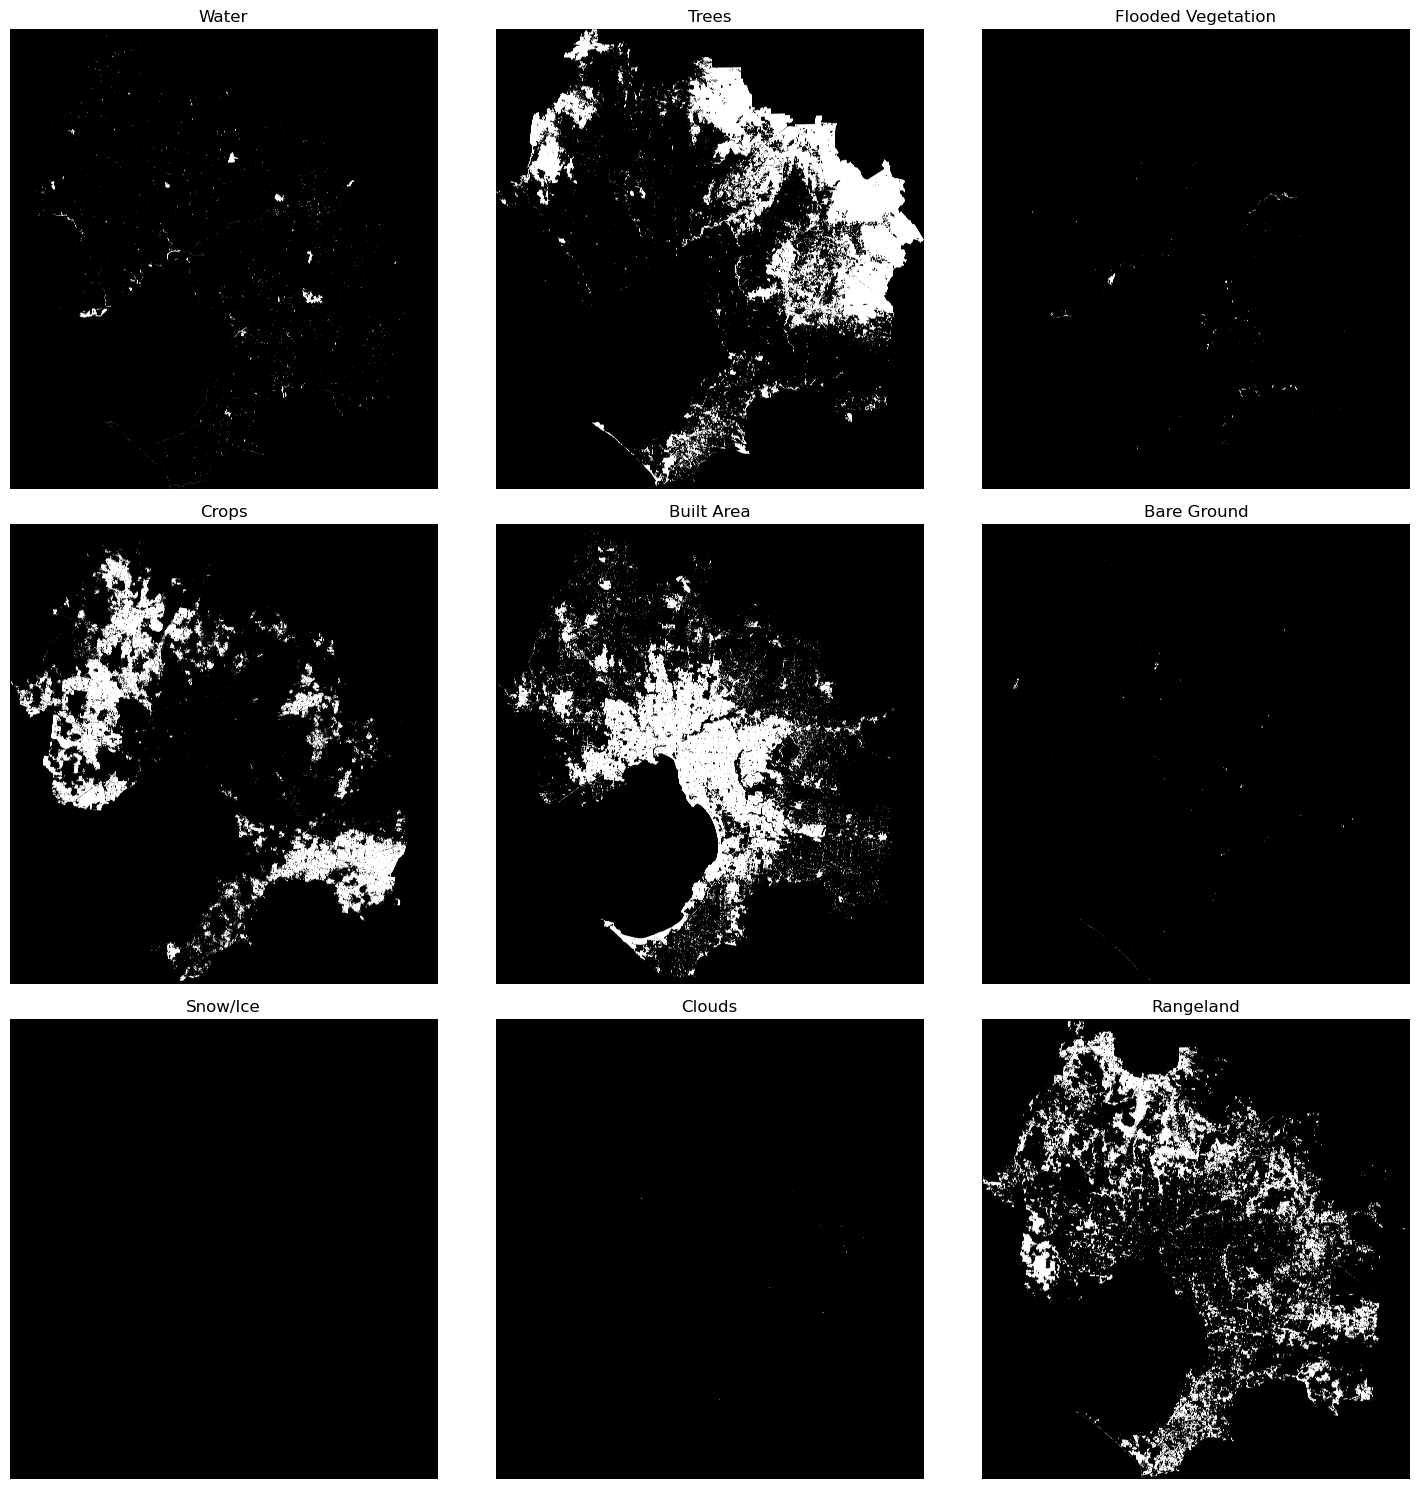

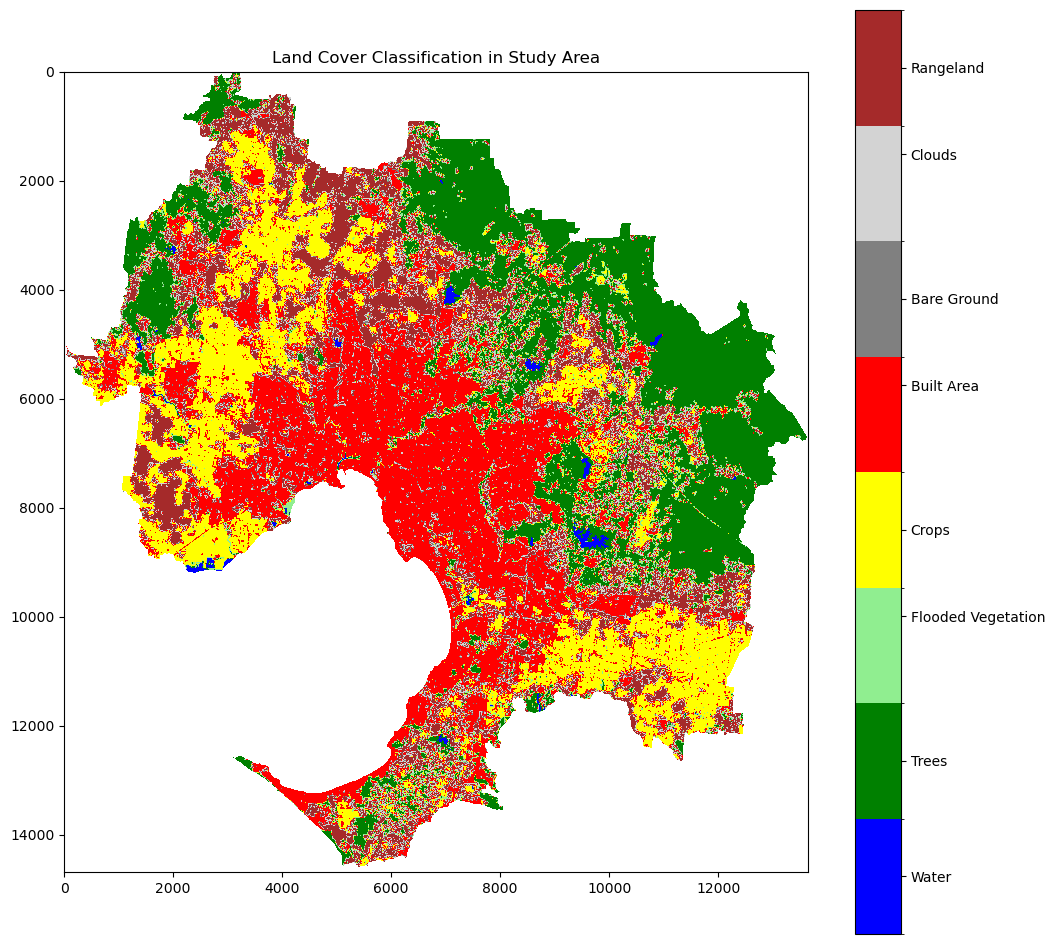

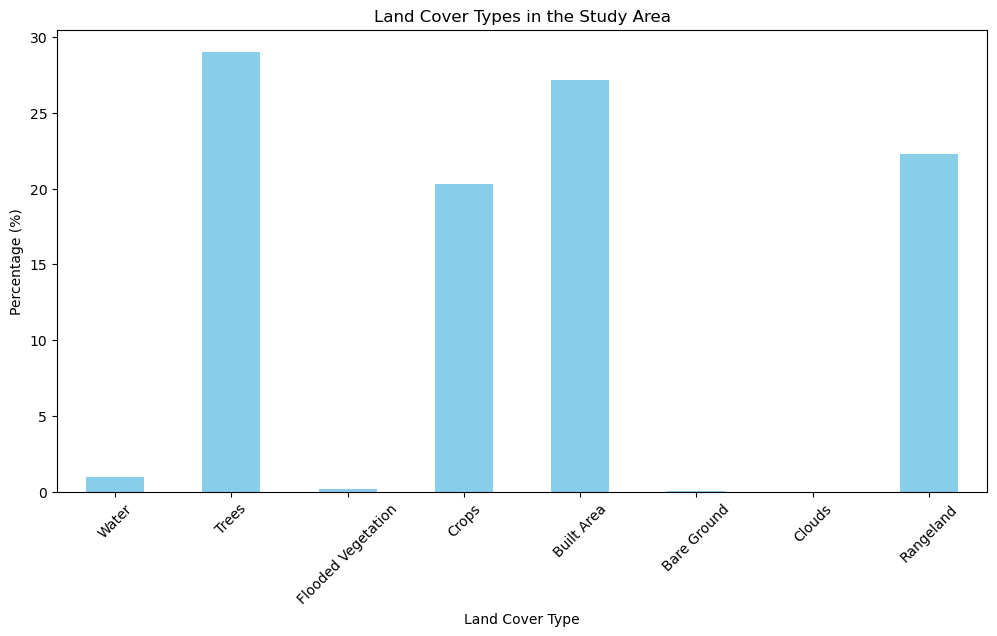

In [23]:
# Colour mapping
colors = ['blue', 'green', 'lightgreen', 'yellow', 'red', 'gray', 'lightgrey', 'brown']
labels = ['Water', 'Trees', 'Flooded Vegetation', 'Crops', 'Built Area', 'Bare Ground', 'Clouds', 'Rangeland']

cmap = mcolors.ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 4.5, 5.5, 7.5, 8.5, 10.5, 11.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Read cropped tif file and generate visualisation
clipped_tif = 'data/55H_20210101-20220101_clipped.tif'
with rasterio.open(clipped_tif) as src:
    band = src.read(1)
    # 将 NoData 值设置为 NaN
    band = np.where(band == src.nodata, np.nan, band)

# Checking for unique values and frequency
unique, counts = np.unique(band[~np.isnan(band)], return_counts=True)
land_cover_stats = pd.DataFrame({'Land_Cover_Type': unique, 'Count': counts})
land_cover_stats['Land_Cover_Name'] = land_cover_stats['Land_Cover_Type'].map(land_cover_names)
land_cover_stats['Percentage'] = (land_cover_stats['Count'] / land_cover_stats['Count'].sum()) * 100
land_cover_stats = land_cover_stats.dropna(subset=['Land_Cover_Name'])  # 去除NaN行
print(land_cover_stats)


# Images for each land cover type
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i, (land_cover_type, name) in enumerate(land_cover_names.items()):
    mask = (band == land_cover_type)
    axs[i].imshow(mask, cmap='gray')
    axs[i].set_title(name)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# land cover classification maps
fig, ax = plt.subplots(figsize=(12, 12))
masked_band = np.where(band != 0, band, np.nan)
cax = ax.imshow(masked_band, cmap=cmap, norm=norm)

cbar = fig.colorbar(cax, ticks=[1, 2, 4, 5, 7, 8, 10, 11], orientation='vertical')
cbar.ax.set_yticklabels(labels)

ax.set_title('Land Cover Classification in Study Area')

plt.show()

# distribution histograms
fig, ax = plt.subplots(figsize=(12, 6))
land_cover_stats.plot(kind='bar', x='Land_Cover_Name', y='Percentage', ax=ax, legend=False, color='skyblue')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Land Cover Type')
ax.set_title('Land Cover Types in the Study Area')
plt.xticks(rotation=45)
plt.show()


We now know that there is no 9 type, thus indicating that the study area does not include data for 9: 'Snow/Ice'

#### 6.3.3 Crime

In [5]:
table_03_df.describe()

Year      Postcode  Incidents Recorded
count  33890.0  33890.000000        33890.000000
mean    2021.0   3393.282709           10.246828
std        0.0    311.407833           29.056708
min     2021.0   3000.000000            1.000000
25%     2021.0   3133.000000            1.000000
50%     2021.0   3311.000000            2.000000
75%     2021.0   3673.000000            7.000000
max     2021.0   3996.000000         1326.000000

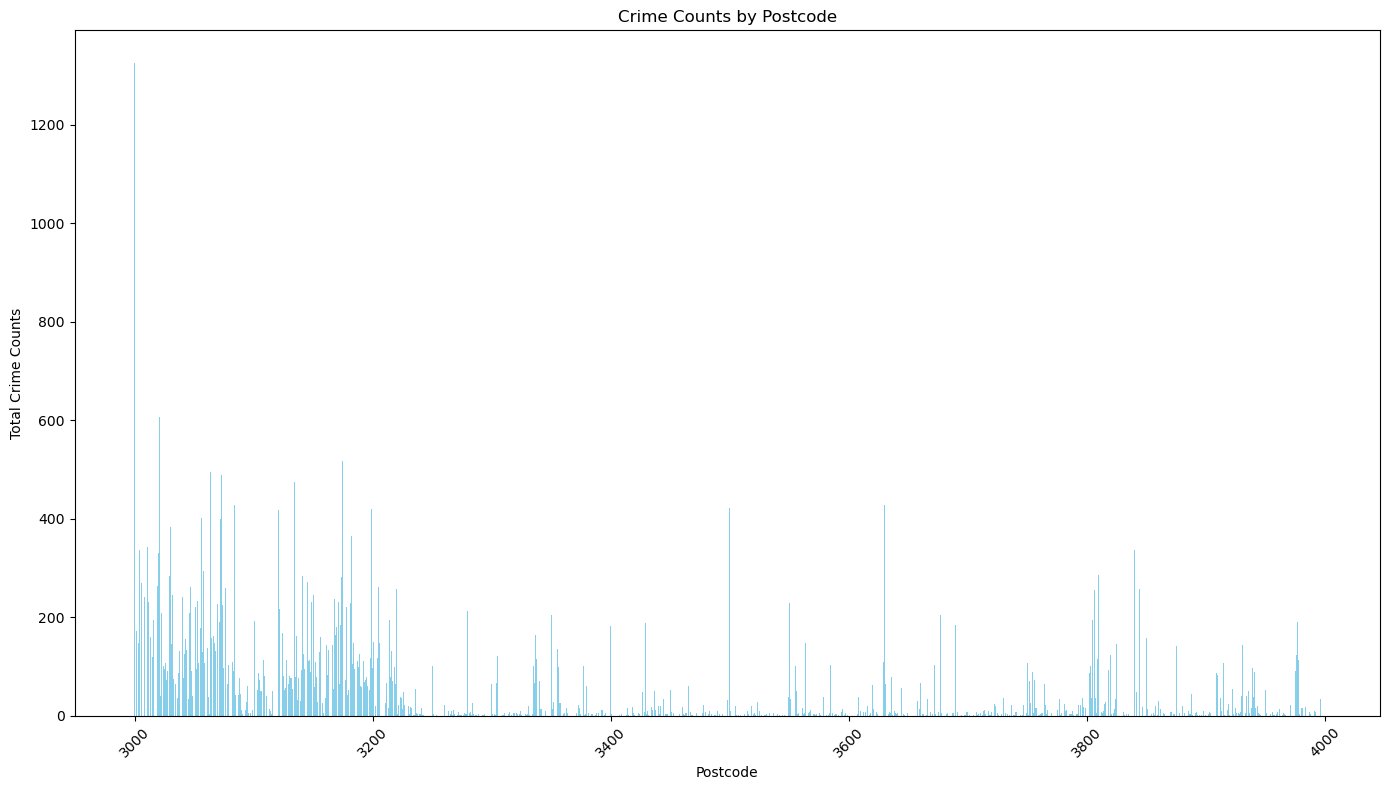

In [4]:
plt.figure(figsize=(14, 8))
plt.bar(table_03_df['Postcode'], table_03_df['Incidents Recorded'], color='skyblue')
plt.xlabel('Postcode')
plt.ylabel('Total Crime Counts')
plt.title('Crime Counts by Postcode')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

### General Observations:
1. **Variability in Crime Counts**: The chart shows significant variability in crime counts across different postcodes. Some postcodes exhibit very high crime counts, while others have relatively few recorded incidents.
2. **Peaks in Crime Counts**: There are noticeable peaks in crime at certain postcodes, which could indicate areas with higher population densities, commercial activities, or other factors that typically correlate with higher crime rates.
3. **Sparse Data in Some Areas**: Several postcodes appear to have very low crime counts. This could either reflect genuinely safer areas, lower population densities, or perhaps areas not fully covered by the dataset.

## 6.4.Methods of analysis

### 6.4.1 Scenario1 : Landmarks

#### 6.4.1.1 Correlation

The analysis involved spatially joining geographical data on universities, hospitals, and stations with census polygons to explore their relationship with median weekly rent. After filtering landmarks data for specific types, these were intersected with census polygons to ensure relevance to the study area. Duplicate entries were cleaned, and indices were reset for data consistency.

Counts of universities, hospitals, and stations per census polygon were calculated and added to the census GeoDataFrame. This setup facilitated the exploration of correlations between landmark density and housing costs through scatter plots, which visually depicted these relationships. Each correlation coefficient was computed to quantify the impacts of these infrastructural elements on rent prices, providing key insights into urban planning and socioeconomic factors.

##### 6.4.1.1.1 University

Correlation between university count and median weekly rent: 0.06712217945869706


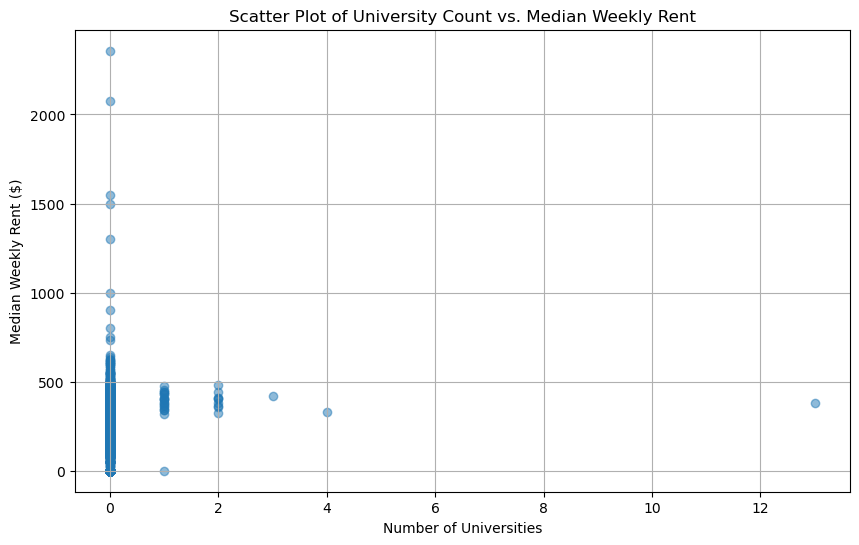

In [28]:
universities_gdf = landmarks_gdf[landmarks_gdf['type'] == 'university']

university_joined = gpd.sjoin(census_polygons, universities_gdf, how="left", predicate="intersects")

university_joined = university_joined.drop_duplicates(subset=['index_right']).reset_index()

university_counts = university_joined.groupby(university_joined['index']).size()

census_polygons['university_count'] = university_counts.reindex(census_polygons.index, fill_value=0)

correlation_uni = census_polygons['Median_rent_weekly'].corr(census_polygons['university_count'])
print(f"Correlation between university count and median weekly rent: {correlation_uni}")

census_polygons = census_polygons.dropna(subset=['Median_rent_weekly', 'university_count'])

plt.figure(figsize=(10, 6))
plt.scatter(census_polygons['university_count'], census_polygons['Median_rent_weekly'], alpha=0.5)
plt.title('Scatter Plot of University Count vs. Median Weekly Rent')
plt.xlabel('Number of Universities')
plt.ylabel('Median Weekly Rent (AUD)')
plt.grid(True)
plt.show()

With 0 universities, rent primarily clusters below 500 AUD, with some points between 500 and 1500 AUD.

With 1 or 2 universities, rent predominantly ranges between 1000 and 1500 AUD.

At 4 or more universities, there are fewer data points, all above 1500 AUD.

##### 6.4.1.1.2 Hospitals

Correlation between hospital count and median weekly rent: 0.14540066002822993


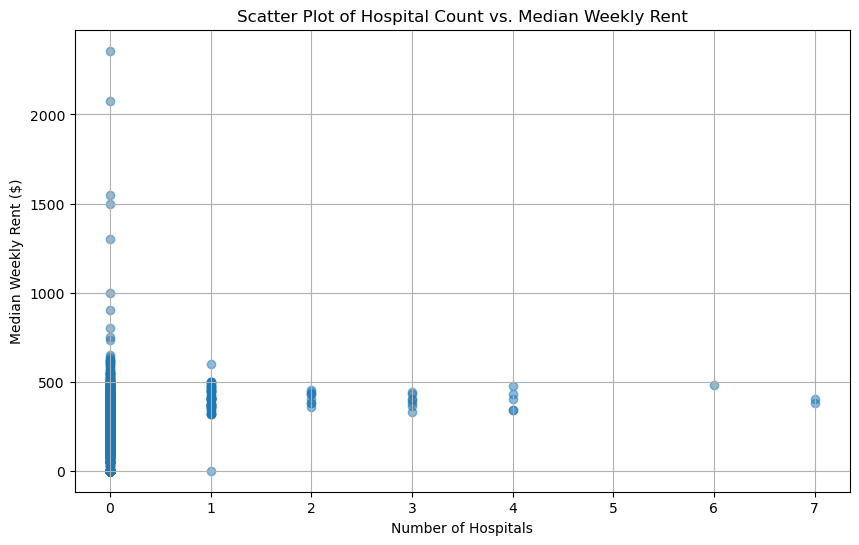

In [29]:
hospitals_gdf = landmarks_gdf[landmarks_gdf['type'] == 'hospital']

hospital_joined = gpd.sjoin(census_polygons, hospitals_gdf, how="left", predicate="intersects")

hospital_joined = hospital_joined.drop_duplicates(subset=['index_right']).reset_index()

hospital_counts = hospital_joined.groupby(hospital_joined['index']).size()

census_polygons['hospital_count'] = hospital_counts.reindex(census_polygons.index, fill_value=0)

correlation_hosp = census_polygons['Median_rent_weekly'].corr(census_polygons['hospital_count'])
print(f"Correlation between hospital count and median weekly rent: {correlation_hosp}")

census_polygons = census_polygons.dropna(subset=['Median_rent_weekly', 'hospital_count'])

plt.figure(figsize=(10, 6))
plt.scatter(census_polygons['hospital_count'], census_polygons['Median_rent_weekly'], alpha=0.5)
plt.title('Scatter Plot of Hospital Count vs. Median Weekly Rent')
plt.xlabel('Number of Hospitals')
plt.ylabel('Median Weekly Rent (AUD)')
plt.grid(True)
plt.show()

With 0 hospitals, rent spans from near 0 AUD up to 2000 AUD.

With 1 hospital, rent points are found below 500 AUD and between 1000 to 1500 AUD.

With 2 or 3 hospitals, rent mostly falls between 500 and 1000 AUD.

##### 6.4.1.1.3 Station

Correlation between station count and median weekly rent: 0.25251122373901874


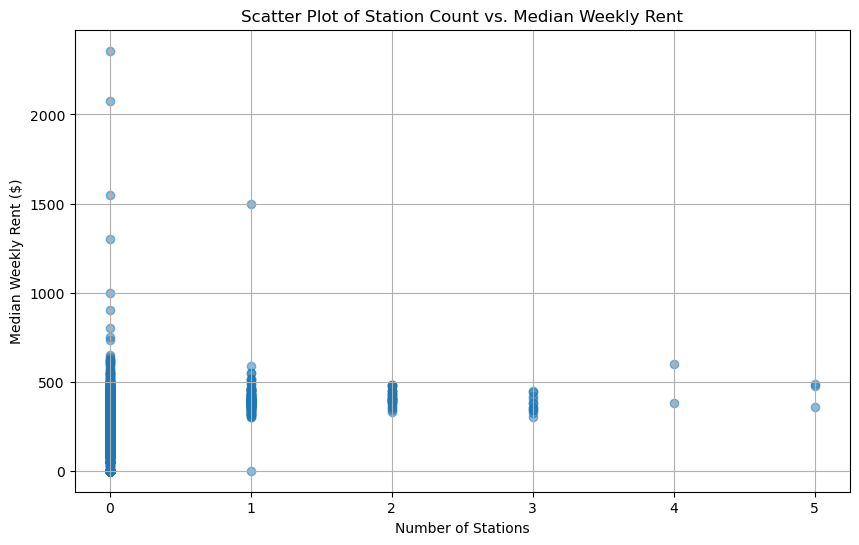

In [30]:
stations_gdf = landmarks_gdf[landmarks_gdf['type'] == 'station']

station_joined = gpd.sjoin(census_polygons, stations_gdf, how="left", predicate="intersects")

station_joined = station_joined.drop_duplicates(subset=['index_right']).reset_index()

station_counts = station_joined.groupby(station_joined['index']).size()

census_polygons['station_count'] = station_counts.reindex(census_polygons.index, fill_value=0)

correlation_station = census_polygons['Median_rent_weekly'].corr(census_polygons['station_count'])
print(f"Correlation between station count and median weekly rent: {correlation_station}")

census_polygons = census_polygons.dropna(subset=['Median_rent_weekly', 'station_count'])

plt.figure(figsize=(10, 6))
plt.scatter(census_polygons['station_count'], census_polygons['Median_rent_weekly'], alpha=0.5)
plt.title('Scatter Plot of Station Count vs. Median Weekly Rent')
plt.xlabel('Number of Stations')
plt.ylabel('Median Weekly Rent (AUD)')
plt.grid(True)
plt.show()

With 0 or 1 station, rent varies from nearly 0 AUD to 2000 AUD.

With 2 stations, rent is distributed between 500 and 1000 AUD.

With 3 or more stations, the rent is primarily below 1000 AUD.

#### 6.4.1.2 Moran’s I index and  Moran’s scatterplot

Using a K-Nearest Neighbors (KNN) weight matrix constructed from the clipped data, the script performs spatial autocorrelation analysis. The KNN matrix, set for five neighbors and row-standardized, supports both Global and Local Moran's I tests. These tests assess whether the distribution of each variable is clustered, dispersed, or random.

Global Moran's I results are visualized in scatter plots, while Local Indicators of Spatial Association (LISA) reveal clusters of high or low values across the region. Enhancements such as scale bars and north arrows improve map usability and interpretation, aiding urban planners and policymakers in understanding local spatial dynamics and guiding regional development.

In [31]:
census_polygons = census_polygons.dropna(subset=['Median_rent_weekly', 'university_count', 'hospital_count', 'station_count'])
census_polygons_clipped = gpd.clip(census_polygons, greater_melbourne_study_area)

w = KNN.from_dataframe(census_polygons_clipped, k=5)
w.transform = 'R'

def analyze_variable(data, variable, title):
    # Global Moran's I
    moran_global = Moran(data[variable], w)
    print(f"Global Moran's I for {title}: {moran_global.I}")

    # Plot Global Moran's I
    plot_moran(moran_global)
    plt.title(f"Moran's I Reference and Scatterplot for {title}")
    plt.show()

    # Local Moran's I
    moran_local = Moran_Local(data[variable], w)

    # Plot LISA Cluster
    fig, ax = plt.subplots(figsize=(10, 10))
    lisa_cluster(moran_local, data, p=0.05, ax=ax)
    ax.set_title(f"LISA Cluster Map for {title}")

    scalebar = AnchoredSizeBar(ax.transData, 1, '1 km', 'lower left', 
                               pad=0.1, color='black', frameon=False, size_vertical=0.01,
                               fontproperties=fm.FontProperties(size=12))
    ax.add_artist(scalebar)

    ax.annotate('N', xy=(0.1, 0.1), xytext=(0.1, 0.2),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=12, xycoords=ax.transAxes)

    plt.show()

##### 6.4.1.2.1 Median Rent Weekly

Global Moran's I for Median Rent Weekly: 0.21812281317052884


/Users/albert/anaconda3/envs/SDA/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


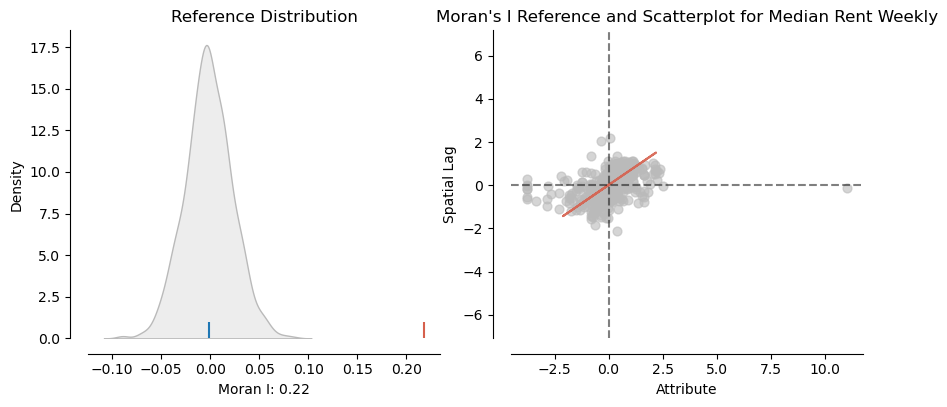

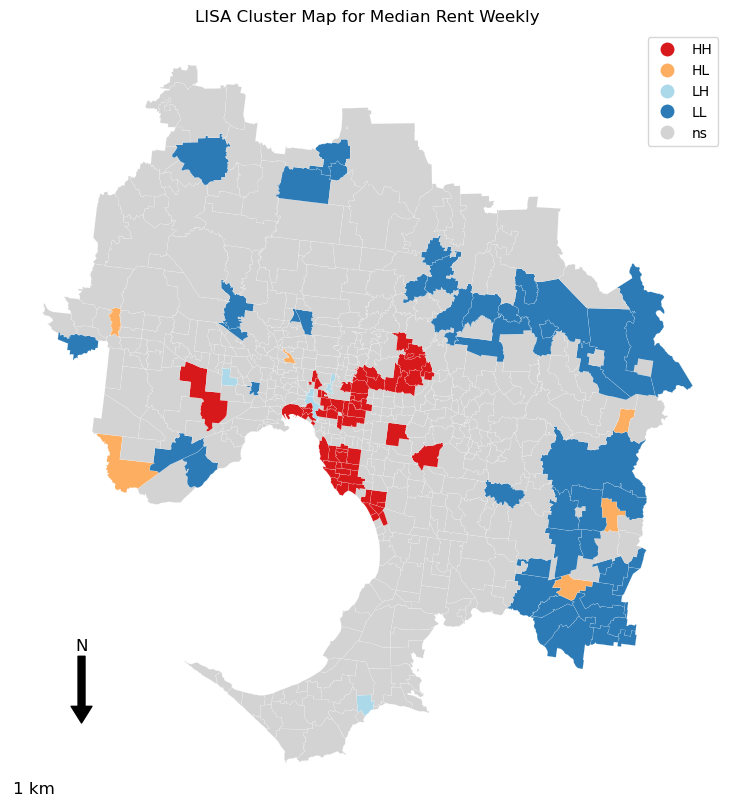

In [32]:
analyze_variable(census_polygons_clipped, 'Median_rent_weekly', 'Median Rent Weekly')

1. **Scenario Description - Median_rent_weekly:**
   - **Moran's I Statistic for Median Rent Weekly**:
     - **Index Value**: The calculated Moran's I index of 0.218 demonstrates positive spatial autocorrelation in the "Median_rent_weekly" attribute across the Greater Melbourne area. This indicates that similar rent values are geographically clustered.
     - **Reference Distribution and Scatterplot**: The reference distribution plot illustrates the position of the Moran's I value relative to a normal distribution assumed under spatial randomness. The Moran's I scatterplot visualizes the relationship between spatial lag and median weekly rent values, with a trend indicated by a red line.

2. **LISA Cluster Map Analysis - Median Rent Weekly**:
   - **Map Explanation**: The LISA (Local Indicators of Spatial Association) Cluster Map delineates significant local spatial autocorrelation patterns in Greater Melbourne, categorizing areas into HH (high-high), LL (low-low), LH (low-high), and HL (high-low) based on their rent values relative to neighboring areas.

##### 6.4.1.2.2 University

Global Moran's I for University Count: 0.16082166333238068


/Users/albert/anaconda3/envs/SDA/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


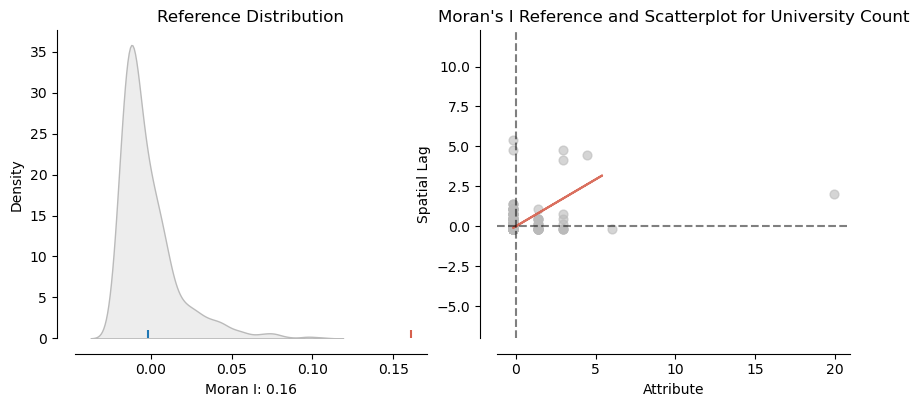

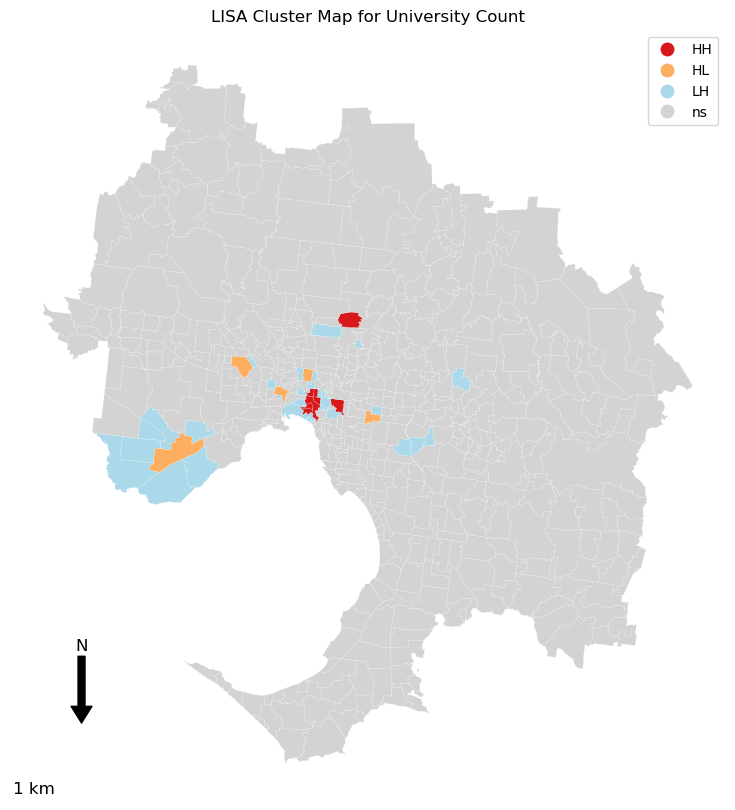

In [33]:
analyze_variable(census_polygons_clipped, 'university_count', 'University Count')

**1.Scenario Description - University Count:**
- **Moran's I Statistic for University Count**:
  - **Index Value**: The calculated Moran's I index of 0.16 for "University Count" demonstrates a positive but relatively weaker spatial autocorrelation across the Greater Melbourne area. This suggests a moderate level of clustering among areas with higher counts of universities.
  - **Reference Distribution and Scatterplot**: The reference distribution shows where the Moran's I value falls relative to a normal distribution under spatial randomness. The Moran's I scatterplot visualizes the relationship between spatial lag and university counts, highlighted by a red trend line.
  - **Selected Point Analysis**: Analyzing a point near an attribute value of 15 and spatial lag of 5, situated in the LH quadrant, shows an area with a moderate count of universities surrounded by areas with higher counts.

**2. LISA Cluster Map Analysis - University Count:**
- **Map Explanation**: The LISA (Local Indicators of Spatial Association) Cluster Map categorizes significant local spatial autocorrelation patterns in Greater Melbourne. Areas are classified into HH (high-high), LL (low-low), LH (low-high), and HL (high-low) based on their university counts relative to neighboring areas.

##### 6.4.1.2.3 Hospitals

Global Moran's I for Hospital Count: 0.06768416556408682


/Users/albert/anaconda3/envs/SDA/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


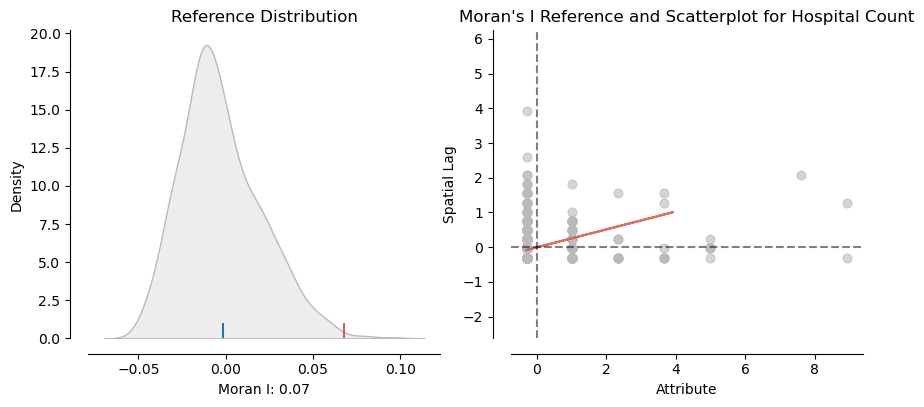

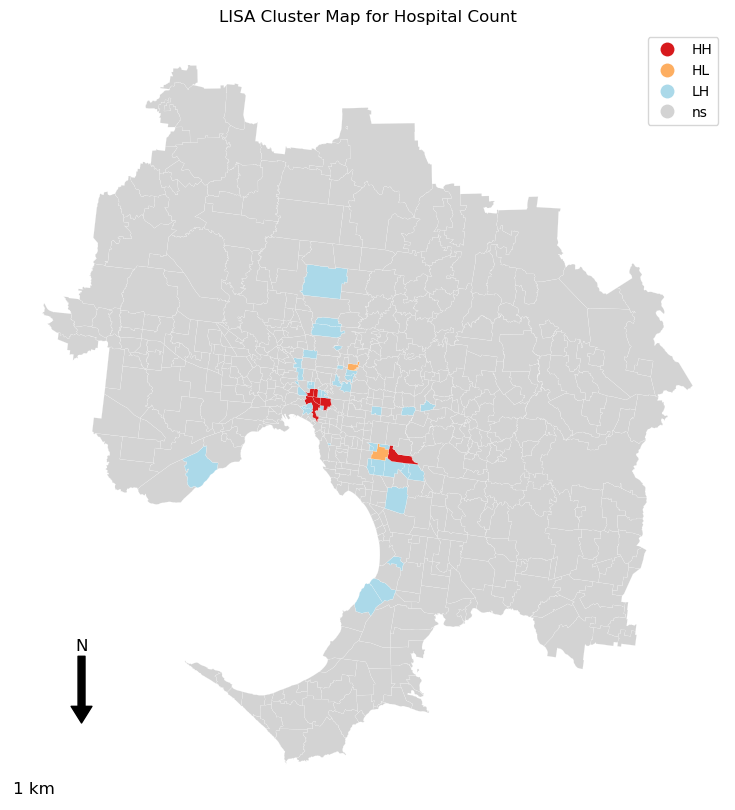

In [34]:
analyze_variable(census_polygons_clipped, 'hospital_count', 'Hospital Count')

**1. Scenario Description - Hospital Count:**
- **Moran's I Statistic for Hospital Count**:
  - **Index Value**: The calculated Moran's I index of 0.07 for "Hospital Count" indicates very weak spatial autocorrelation, suggesting that hospitals are distributed more randomly across Greater Melbourne than other facilities such as universities or stations.
  - **Reference Distribution and Scatterplot**: The reference distribution is broader with a flatter peak around a lower Moran's I value, indicating minimal clustering. The Moran's scatterplot primarily shows data points near the origin, confirming the low level of spatial dependency among hospital locations.
  - **Selected Point Analysis**: Choosing the point roughly at Attribute = 2 and Spatial Lag = 0, situated in the LL quadrant, indicates an area with a low number of hospitals surrounded by areas with similarly low counts. This may suggest a region with limited medical facilities, potentially a more remote or sparsely populated area.

**2. LISA Cluster Map Analysis - Hospital Count:**
- **Map Explanation**: The LISA (Local Indicators of Spatial Association) Cluster Map delineates significant local spatial autocorrelation patterns for hospital counts in Greater Melbourne, classifying areas into HH (high-high), LL (low-low), LH (low-high), and HL (high-low) based on their hospital counts relative to neighboring areas.

##### 6.4.1.2.4 Station

Global Moran's I for Station Count: 0.21503834864122717


/Users/albert/anaconda3/envs/SDA/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


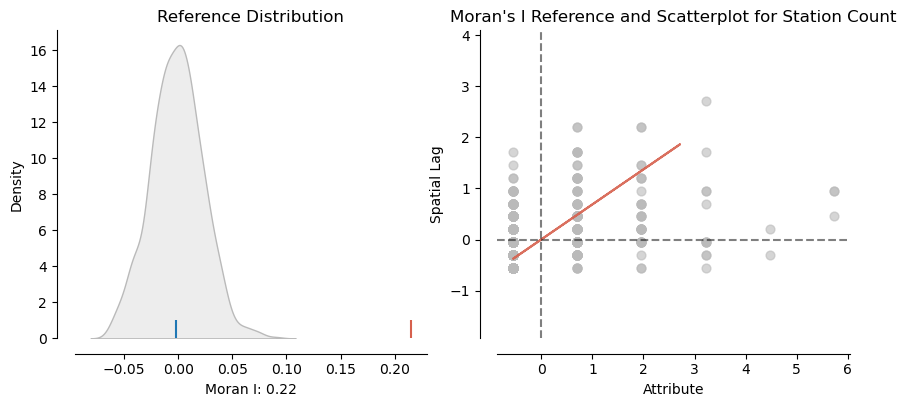

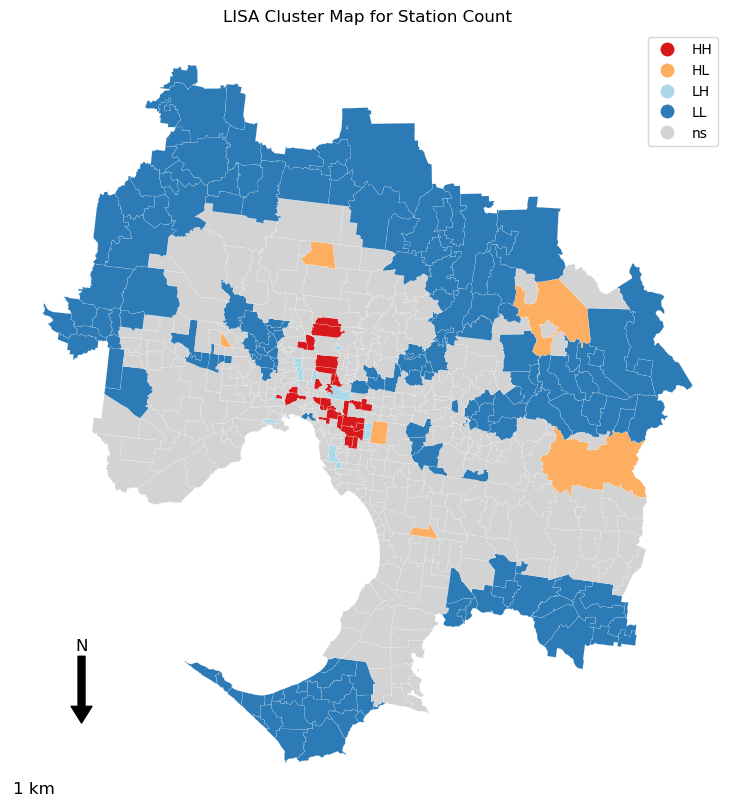

In [35]:
analyze_variable(census_polygons_clipped, 'station_count', 'Station Count')

1. **Understanding Positive Spatial Autocorrelation in Station Count**:
   - **Moran's I Statistic for Station Count**:
     - **Index Value**: The calculated Moran's I index of 0.22 indicates a positive spatial autocorrelation, suggesting that areas with higher numbers of stations tend to cluster together, indicative of organized transit planning in urbanized areas.
     - **Reference Distribution and Scatterplot**: The reference distribution shows a normal-like peak around a Moran's I value of 0.22, suggesting moderate clustering. The scatterplot illustrates this with several data points falling within the HH quadrant, highlighted by a red trend line showing the relationship between station count and spatial lag.
   - **Selected Point Analysis**: Analyzing a point near an attribute value of 5 and spatial lag of 2, situated in the HH quadrant, this indicates a central urban area with a high number of stations. The surrounding area also reflects high station density, typically seen in well-developed public transport networks.

2. **Implications of LISA Cluster Map Results for Urban Planning and Policy**:
   - **Map Explanation**: The LISA (Local Indicators of Spatial Association) Cluster Map illustrates how station counts in Greater Melbourne are distributed into various clusters such as HH (high-high), LL (low-low), LH (low-high), and HL (high-low) based on their counts relative to neighboring areas.

#### 6.4.1.3 Further research

#### 6.4.1.3.1 Dataset Analysis

In [40]:
top_rent_areas = census_polygons.sort_values(by='Median_rent_weekly', ascending=False).head(10)
print(top_rent_areas[['SAL_NAME_2021', 'Median_rent_weekly']])

          SAL_NAME_2021  Median_rent_weekly
2687        Waratah Bay              2358.0
288      Boolarra South              2077.0
1416        Laanecoorie              1550.0
2140          Ravenhall              1500.0
1127           Hallston              1300.0
2884         Wyuna East              1000.0
2072  Pine Grove (Vic.)               900.0
547   Chewton Bushlands               800.0
1838        Murra Warra               750.0
347      Brodribb River               735.0


##### Despite lacking typical urban amenities like universities, hospitals and train stations, these areas can still drive higher rents.

In [41]:
print(landmarks_gdf['type'].unique())

def calculate_nearest(gdf, landmarks, landmark_type):
    distances = []
    subset_landmarks = landmarks[landmarks['type'] == landmark_type]
    for geom in gdf.geometry:
        if geom is None or subset_landmarks.empty:
            distances.append(None)
        else:
            min_distance = subset_landmarks.distance(geom).min()
            distances.append(min_distance)
    return distances

census_polygons['distance_to_nearest_university'] = calculate_nearest(census_polygons, landmarks_gdf, 'university')
census_polygons['distance_to_nearest_hospital'] = calculate_nearest(census_polygons, landmarks_gdf, 'hospital')
census_polygons['distance_to_nearest_station'] = calculate_nearest(census_polygons, landmarks_gdf, 'station')

print(census_polygons[['distance_to_nearest_university', 'distance_to_nearest_hospital', 'distance_to_nearest_station']].head())

['station' 'hospital' 'university']
   distance_to_nearest_university  distance_to_nearest_hospital  \
0                   137669.763929                 117300.660656   
1                      957.926109                    500.997570   
2                     3042.065943                    702.879323   
3                    89068.544954                  73125.032992   
4                    56411.601526                  38348.098053   

   distance_to_nearest_station  
0                119170.549773  
1                     0.000000  
2                   781.537675  
3                 71004.675145  
4                 39644.079756  


#### 6.4.1.3.2 Spatial Data Analysis

An ordinary least squares (OLS) regression is first applied to identify linear relationships between rent and distances. The results highlight the influence of each factor on rent.

Additionally, a spatial lag model is employed to adjust for spatial autocorrelation in the residuals of the OLS model, enhancing the model's accuracy.

In [42]:
valid_census_polygons = census_polygons[~census_polygons['geometry'].isnull()].copy()

w = Queen.from_dataframe(valid_census_polygons)

w.transform = 'r'

print(w.histogram)
print(w.s0)

features = ['distance_to_nearest_university', 'distance_to_nearest_hospital', 'distance_to_nearest_station']
X = valid_census_polygons[features].values
X = sm.add_constant(X)  
y = valid_census_polygons['Median_rent_weekly'].values

ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

from spreg import ML_Lag
model = ML_Lag(y, X, w)
print(model.summary)

/var/folders/5y/njtspfy96vj3th5cqr1r_pf40000gn/T/ipykernel_23912/3676449099.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(valid_census_polygons)
/Users/albert/anaconda3/envs/SDA/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 561, 855, 951, 2299.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 561, ' is an island (no neighbors)')
('WARNING: ', 855, ' is an island (no neighbors)')
('WARNING: ', 951, ' is an island (no neighbors)')
('WARNING: ', 2299, ' is an island (no neighbors)')
[(0, 4), (1, 19), (2, 73), (3, 215), (4, 452), (5, 620), (6, 601), (7, 451), (8, 261), (9, 136), (10, 68), (11, 20), (12, 10), (13, 7), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1)]
2940.0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     424.1
Date:                Sat, 08 Jun 2024   Prob (F-statistic):          6.11e-229
Time:                        14:30:13   Log-Likelihood:                -18584.
No. Observations:                2944   AIC:                         3.718e+04
Df Residuals:                    2940   BIC:          

##### Data Interpretation

- **Distance to nearest university (x1)**: The coefficient is -0.0060, which indicates that for every unit increase in distance from the nearest university, the median weekly rent changes by approximately -$0.006 AUD.
  
- **Distance to nearest hospital (x2)**: The coefficient is 0.0036, suggesting a change of +$0.0036 AUD in median weekly rent for every unit increase in distance from the nearest hospital.

- **Distance to nearest station (x3)**: The coefficient is 0.0017, indicating that for each unit increase in distance from the nearest station, there's an increase of +$0.0017 AUD in the median weekly rent.

- **Spatial Dependency (W_dep_var)**: The coefficient is 0.4339, showing a significant influence of spatial factors on the median weekly rent, highlighting that rent values are not only determined by the immediate attributes but also by the surrounding area's characteristics.

### 6.4.2 Scenario2 : Landuse

#### 6.4.2.1 Overlay of Raster Data with Census Polygons and Rent Analysis by Land Use Type

The process involved using spatial overlay techniques to intersect land cover data (derived from raster imagery) with census polygons for the Greater Melbourne study area. By converting the raster data to vector format, we created a GeoDataFrame that could be spatially overlaid with census data. This allowed for the calculation of average median rent for each land use type within the study area.

   land_cover  Median_rent_weekly     Land_Cover_Name
0         1.0          391.177260               Water
1         2.0          362.694893               Trees
2         4.0          315.666010  Flooded Vegetation
3         5.0          360.909288               Crops
4         7.0          360.554855          Built Area
5         8.0          374.078772         Bare Ground
6        10.0          320.265306              Clouds
7        11.0          359.773252           Rangeland


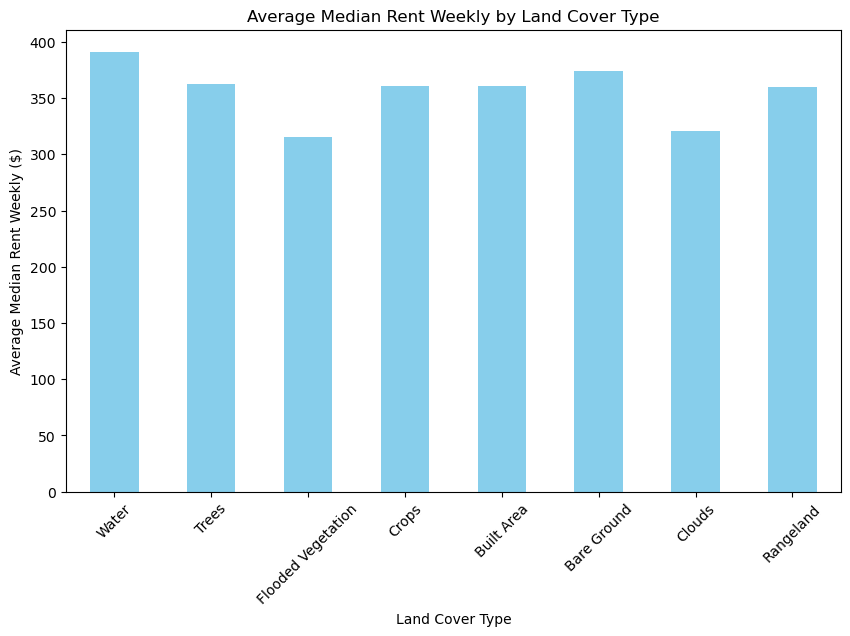

In [36]:
census_polygons_clipped = gpd.clip(census_polygons, greater_melbourne_study_area)

# Converting raster data to vector data
with rasterio.open('data/55H_20210101-20220101_clipped.tif') as src:
    band = src.read(1)
    mask = band != 0  # Remove areas with a value of 0
    shapes_gen = shapes(band, mask=mask, transform=src.transform)
    geoms = [{'geometry': geom, 'properties': {'land_cover': value}} for geom, value in shapes_gen]

# GeoDataFrame
raster_gdf = gpd.GeoDataFrame.from_features(geoms, crs="EPSG:7855")

# Spatial Overlay of Raster Data with Census Polygons
overlay = gpd.overlay(raster_gdf, census_polygons_clipped, how='intersection')

# Calculation of average rent for each land use type
land_cover_rent = overlay.groupby('land_cover')['Median_rent_weekly'].mean().reset_index()
land_cover_rent['Land_Cover_Name'] = land_cover_rent['land_cover'].map(land_cover_names)
print(land_cover_rent)

# Visualising the relationship between land use types and rents
fig, ax = plt.subplots(figsize=(10, 6))
land_cover_rent.plot(kind='bar', x='Land_Cover_Name', y='Median_rent_weekly', ax=ax, legend=False, color='skyblue')
ax.set_ylabel('Average Median Rent Weekly ($)')
ax.set_xlabel('Land Cover Type')
ax.set_title('Average Median Rent Weekly by Land Cover Type')
plt.xticks(rotation=45)
plt.show()



The unweighted results show that average rent for each land cover type is relatively flat with little variation. Specifically, waters had the highest average rent at A$391.18/week, while cloud covered areas had the lowest average rent at A$320.27/week. Other types of land cover, such as trees, crops, built-up areas, and pastures, also had relatively similar average rents.


#### To more accurately reflect the relationship between different land cover types and rents, we can use a weighted average. 

### 6.4.2.2 Weighted Average Rent Calculation and Visualization by Land Use Type

Weighting process:

The proportion of each land cover type's area in each area was multiplied by the rent for that area, and these weighted rents to be summed.

The purpose is to more accurately reflect the actual contribution of each land cover type to rents, as some land cover types occupy larger areas within the study area while others are relatively small.

   land_cover  weighted_rent     Land_Cover_Name
0         1.0    2000.386487               Water
1         2.0   31488.703599               Trees
2         4.0     349.652822  Flooded Vegetation
3         5.0   22719.410597               Crops
4         7.0  131979.898404          Built Area
5         8.0     181.990092         Bare Ground
6        10.0       6.879923              Clouds
7        11.0   32766.078077           Rangeland


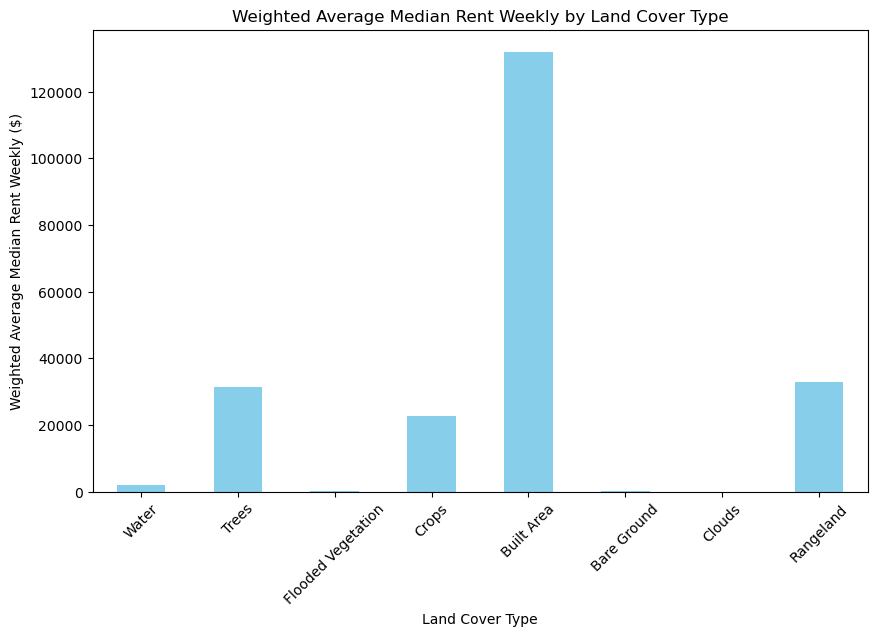

In [37]:
# Spatial overlay of raster data with census polygons
overlay = gpd.overlay(raster_gdf, census_polygons_clipped, how='intersection')

# Calculate the area of each land use type
overlay['area'] = overlay.geometry.area

# Calculate the total area of each area
total_area_per_polygon = overlay.groupby('id')['area'].sum().reset_index().rename(columns={'area': 'total_area'})

# Merge total area information back into the overlay data
overlay = overlay.merge(total_area_per_polygon, on='id')

# Calculate the proportion of each land-use type in each region
overlay['area_ratio'] = overlay['area'] / overlay['total_area']

# Calculation of weighted average rent
overlay['weighted_rent'] = overlay['area_ratio'] * overlay['Median_rent_weekly']
weighted_rent_per_land_cover = overlay.groupby('land_cover')['weighted_rent'].sum().reset_index()
land_cover_rent = weighted_rent_per_land_cover.merge(
    pd.DataFrame.from_dict(land_cover_names, orient='index', columns=['Land_Cover_Name']).reset_index().rename(columns={'index': 'land_cover'}), 
    on='land_cover'
)

print(land_cover_rent)

# Visualisation of weighted average rent
fig, ax = plt.subplots(figsize=(10, 6))
land_cover_rent.plot(kind='bar', x='Land_Cover_Name', y='weighted_rent', ax=ax, legend=False, color='skyblue')
ax.set_ylabel('Weighted Average Median Rent Weekly ($)')
ax.set_xlabel('Land Cover Type')
ax.set_title('Weighted Average Median Rent Weekly by Land Cover Type')
plt.xticks(rotation=45)
plt.show()


The weighted results show that Built Area has the highest weighted average rent well above the other types. This indicates that Built Area contributes the most to the overall rent. Built Area occupies 27.19% of the study area and its high rent significantly boosts the overall rent level.

Tree (Trees) area occupies the largest proportion of land cover (29.02%) and the weighted rent is not as significantly higher as its proportion of cover. This suggests that despite the large size of Trees areas, these areas have lower rent levels and may be located in non-urbanised or semi-urbanised areas.

Rangeland and Crops have a similar property. Although they have relatively large land cover areas, they significantly have much lower rents, relative to the Built Area's cover area and rents.

Flooded Vegetation (Flooded Vegetation) and Clouds (Clouds) areas accounted for a smaller percentage of the area (0.158% and 0.005%, respectively) and had the lowest weighted rents, and these areas have less impact on the overall rents.

### 6.4.2.3 Regression Analysis Using Dummy Variables

Regression analysis is a statistical method used to study the relationship between independent variables (predictor variables) and dependent variables (response variables). By developing a mathematical model, the independent variable can be used to predict the variation of the dependent variable.

In this study, it is used to explore the relationship between land cover type (independent variable) and median weekly rent in the neighbourhood (dependent variable). The aim is to evaluate the impact of different land cover types on rent levels. Then it provides a reference for urban planning and policy formulation.


In [38]:
overlay_with_names = overlay.copy()
overlay_with_names['land_cover_name'] = overlay_with_names['land_cover'].map(land_cover_names)

# Regression analyses using dummy variables
land_cover_dummies = pd.get_dummies(overlay_with_names['land_cover_name'], prefix='land_cover')

# Add to datafrmae 
overlay_with_dummies = pd.concat([overlay_with_names, land_cover_dummies], axis=1)
overlay_with_dummies.columns = [col.replace(' ', '_').replace('(', '').replace(')', '') for col in overlay_with_dummies.columns]

# Update land_cover_dummies columns
land_cover_dummies.columns = [col.replace(' ', '_').replace('(', '').replace(')', '') for col in land_cover_dummies.columns]

# Define a regression formula that removes a baseline category to avoid multi-collinearity
formula = 'Median_rent_weekly ~ ' + ' + '.join(land_cover_dummies.columns.difference(['land_cover_Built_Area']))

# Conduct regression analysis
model = smf.ols(formula=formula, data=overlay_with_dummies).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:     Median_rent_weekly   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     143.5
Date:                Sat, 08 Jun 2024   Prob (F-statistic):          1.36e-211
Time:                        14:28:50   Log-Likelihood:            -6.7602e+05
No. Observations:              113191   AIC:                         1.352e+06
Df Residuals:                  113183   BIC:                         1.352e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### Based on the OLS regression results, we get the following conclusions:

Intercept (constant term): indicates an average weekly rent of $360.55 in the case of the baseline type (built-up area).

Bare Ground: increased by $13.52, indicating that the area covered by bare ground has a positive impact on the rent.

Clouds: decreased by $40.29, indicating that cloud covered areas have a significant negative impact on rent.

Crops: increased by $0.35, indicating that crop covered areas have a significant negative impact on rent.

Flooded Vegetation: decreased by $44.89, Flooded Vegetation areas have a significant negative impact on rents.

Rangeland: decreased by $0.78, with pasture cover areas having a minor impact on rents.

Trees: increased by $2.14, with tree cover areas having a slight positive impact on rents.

Water: an increase of $30.62, with water covered areas having a significant positive impact on rents


#### 6.4.2.4 K-means cluster analysis results


K-means clustering is a popular method used to partition data into distinct groups based on their characteristics. In this analysis, K-means clustering was applied to the land cover type and median rent data to identify patterns and relationships between these variables. The process involved standardizing the data to ensure that differences in scale between variables did not affect the clustering results. The K-means algorithm was then used to classify the data into three clusters (k=3).

/var/folders/5y/njtspfy96vj3th5cqr1r_pf40000gn/T/ipykernel_23912/3490283923.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land_cover_rent['cluster'] = kmeans.labels_


Silhouette Score: 0.42730619776353723
Inertia: 106777.84545184788


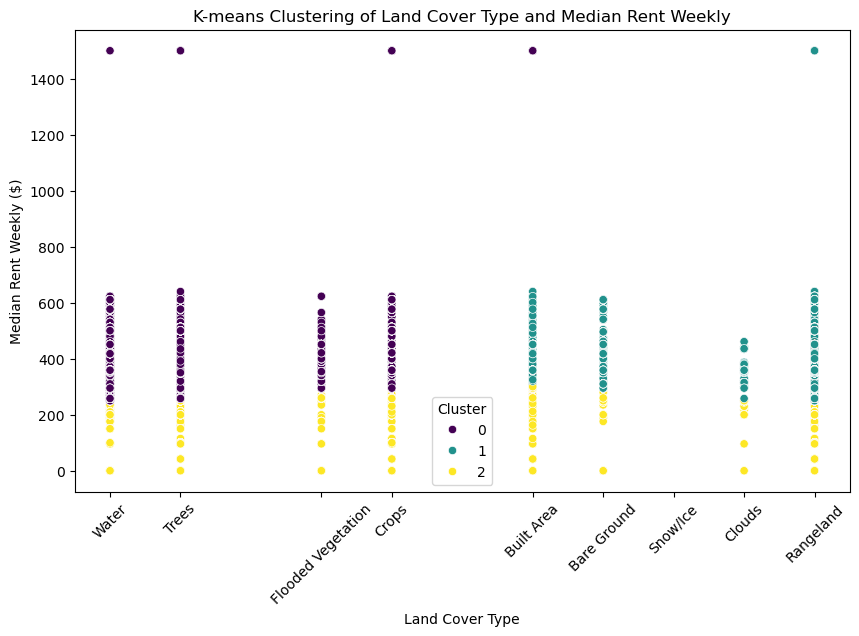

In [39]:
land_cover_rent = overlay[['land_cover', 'Median_rent_weekly']]

# Data standardisation
scaler = StandardScaler()
land_cover_rent_scaled = scaler.fit_transform(land_cover_rent)

# K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(land_cover_rent_scaled)

# Add the clustering results to the original data
land_cover_rent['cluster'] = kmeans.labels_

# Calculation of clustering effect indicators
silhouette_avg = silhouette_score(land_cover_rent_scaled, kmeans.labels_)
inertia = kmeans.inertia_

print(f'Silhouette Score: {silhouette_avg}')
print(f'Inertia: {inertia}')

# Visualisation of clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='land_cover', y='Median_rent_weekly', hue='cluster', palette='viridis', data=land_cover_rent)
plt.xlabel('Land Cover Type')
plt.ylabel('Median Rent Weekly ($)')
plt.title('K-means Clustering of Land Cover Type and Median Rent Weekly')
plt.xticks(ticks=list(land_cover_names.keys()), labels=list(land_cover_names.values()), rotation=45)
plt.legend(title='Cluster')
plt.show()


#### Clustering effect:

The contour coefficient is 0.4273, indicating a moderate clustering effect. The separation between different clusters is good but the tightness within the clusters needs to be improved.
The variance within the clusters is 106777.8454, indicating that the tightness of the samples within the clusters is good but not perfect.

#### Relationship between land cover type and rent:

Cluster 0 (purple): the lowest level of rent, which consists mainly of Flooded Vegetation and Clouds.
Cluster 1 (yellow): Medium rent, mainly Bare Ground, Crops and Trees.
Cluster 2 (green): Highest level of rent, mainly Built Area, Water and Rangeland.


### 6.4.3 Scenario3 : Crime

#### 6.4.3.1 Merge datasets

In [43]:
merged_data = table_03_df.merge(census_polygons, left_on='Suburb/Town Name', right_on='SAL_NAME_2021', how='inner')
crime_counts_by_postcode = merged_data.groupby('Postcode')['Incidents Recorded'].sum().reset_index()

#### 6.4.3.2 Correlation coefficient

Evaluates the relationship between crime rates and median weekly rent by postcode. It calculates average rent per postcode, merges it with crime data, and then analyzes their correlation. The Pearson correlation assesses the linear relationship, while the Spearman correlation examines the rank-order relationship.

In [45]:
average_rent_by_postcode = merged_data.groupby('Postcode')['Median_rent_weekly'].mean().reset_index()

crime_rent_data = pd.merge(crime_counts_by_postcode, average_rent_by_postcode, on='Postcode')

print(crime_rent_data.head())

   Postcode  Incidents Recorded  Median_rent_weekly
0      3000               11207               381.0
1      3002                 796               480.0
2      3003                1048               388.0
3      3004                2177               381.0
4      3006                2774               453.2


In [46]:
correlation = crime_rent_data[['Incidents Recorded', 'Median_rent_weekly']].corr(method='pearson')
print("Pearson correlation coefficient:")
print(correlation)

correlation_spearman = crime_rent_data[['Incidents Recorded', 'Median_rent_weekly']].corr(method='spearman')
print("Spearman correlation coefficient:")
print(correlation_spearman)

Pearson correlation coefficient:
                    Incidents Recorded  Median_rent_weekly
Incidents Recorded            1.000000            0.282525
Median_rent_weekly            0.282525            1.000000
Spearman correlation coefficient:
                    Incidents Recorded  Median_rent_weekly
Incidents Recorded            1.000000            0.588791
Median_rent_weekly            0.588791            1.000000


#### Pearson Correlation Coefficient
- **Incidents Recorded vs. Median_rent_weekly**: 0.282525
  - This positive correlation coefficient indicates a weak positive correlation between crime incidents and rent prices on a general level. It suggests that increases in crime incidents are somewhat associated with higher rents, but the relationship is not particularly strong.

#### Spearman Correlation Coefficient
- **Incidents Recorded vs. Median_rent_weekly**: 0.588791
  - This higher positive correlation coefficient shows a moderate positive correlation between crime incidents and rent. Spearman’s correlation coefficient focuses on the monotonic relationship, indicating that rent tends to increase with the number of crime incidents.

#### 6.4.3.3 Scatter Plot

This scatter plot visually represents the relationship between the number of crime incidents and average median weekly rent across different postcodes. By plotting total recorded incidents against rent, the plot allows for a visual assessment of how changes in crime levels might correspond to variations in rent prices. The plot features grid lines for better readability and transparency settings for the data points to handle overlap, making it easier to observe the density and distribution of points. 

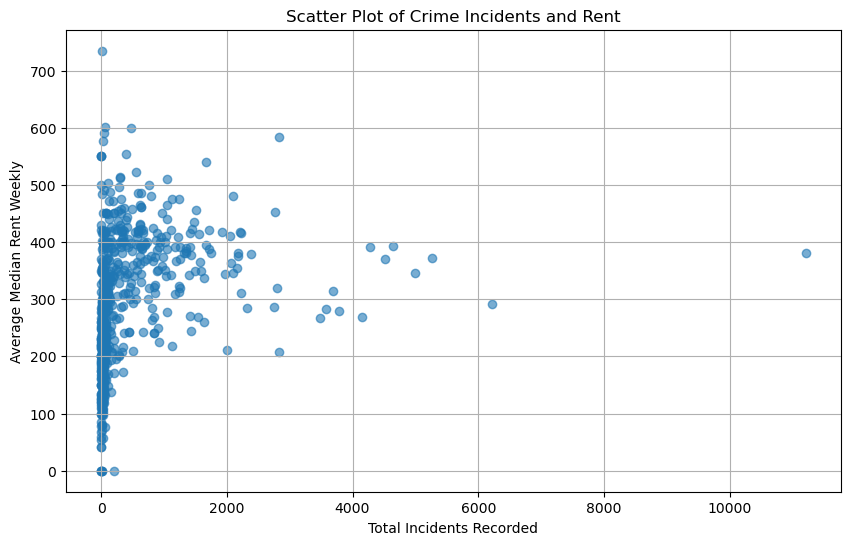

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(crime_rent_data['Incidents Recorded'], crime_rent_data['Median_rent_weekly'], alpha=0.6)
plt.xlabel('Total Incidents Recorded')
plt.ylabel('Average Median Rent Weekly(AUD)')
plt.title('Scatter Plot of Crime Incidents and Rent')
plt.grid(True)
plt.show()

- A dense cluster of data points is visible at the lower end of crime incidents, particularly where the number of incidents is less than 2000.
- Median weekly rent for these points ranges widely from near 0 AUD to approximately 700 AUD.
- As the number of crime incidents increases, particularly beyond 2000, the data points become sparse.
- Median weekly rent in areas with higher crime incidents generally does not exceed 600 AUD.
- There is an outlier at the far right of the plot, where crime incidents approach 10000, with the rent around the mid-range of values observed across the plot.

#### 6.4.3.4 Further research

##### why choose Incidents Recorded from 1000 to 6000

The selection of crime records in the range of 1000 to 6000 may be to ensure that the analyzed data has a sufficient sample size, thereby improving the reliability of statistical analysis. Crime records that are too low may not be enough to show obvious trends or patterns, while data that are too high may be outliers, which may represent extreme cases and may not necessarily reflect the general situation.

In [48]:
grouped_data = merged_data.groupby('Postcode').agg({
    'Incidents Recorded': 'sum', 
    'geometry': 'first',  
    'Median_rent_weekly': 'mean'  
}).reset_index()

filtered_data = grouped_data[(grouped_data['Incidents Recorded'] >= 1000) & (grouped_data['Incidents Recorded'] <= 6000)]
filtered_data.head()

Postcode  Incidents Recorded  \
2      3003                1048   
3      3004                2177   
4      3006                2774   
5      3008                2048   
6      3011                2158   

                                            geometry  Median_rent_weekly  
2  MULTIPOLYGON (((319785.247 5812979.926, 319718...               388.0  
3  MULTIPOLYGON (((321195.605 5813623.946, 321380...               381.0  
4  MULTIPOLYGON (((319401.361 5811592.926, 319412...               453.2  
5  MULTIPOLYGON (((319770.388 5811768.157, 319559...               411.0  
6  MULTIPOLYGON (((315696.276 5813255.740, 315694...               355.0

##### 6.4.3.4.1 Histogram

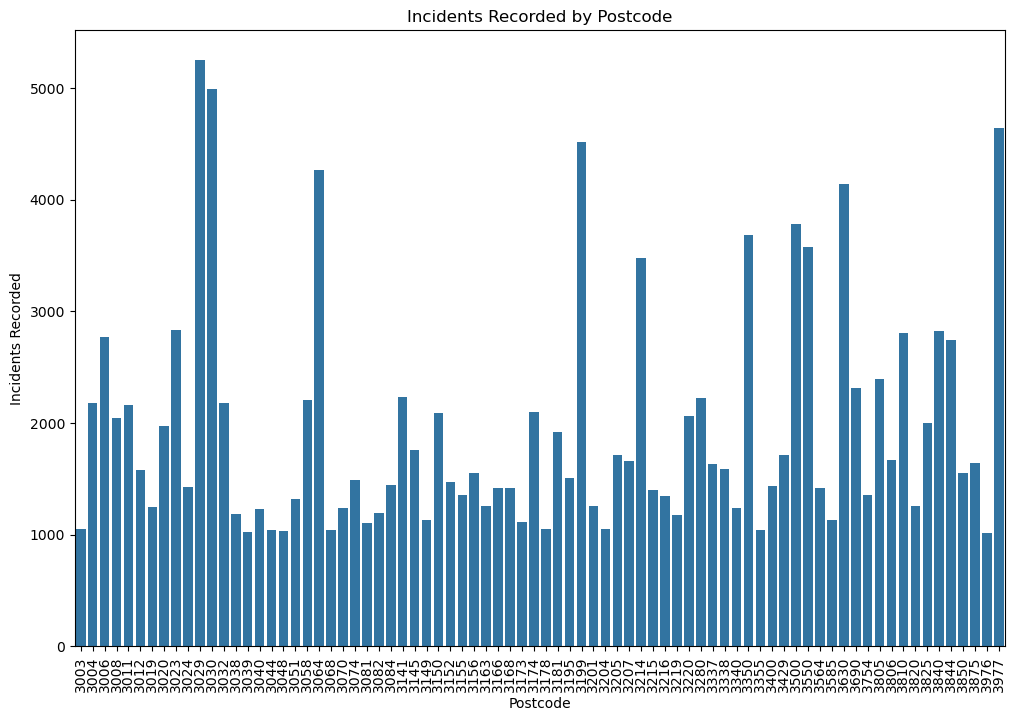

In [49]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Postcode', y='Incidents Recorded', data=filtered_data)

plt.title('Incidents Recorded by Postcode')
plt.xlabel('Postcode')
plt.ylabel('Incidents Recorded')
plt.xticks(rotation=90)  
plt.show()

##### 6.4.3.4.2 Scatter Plot

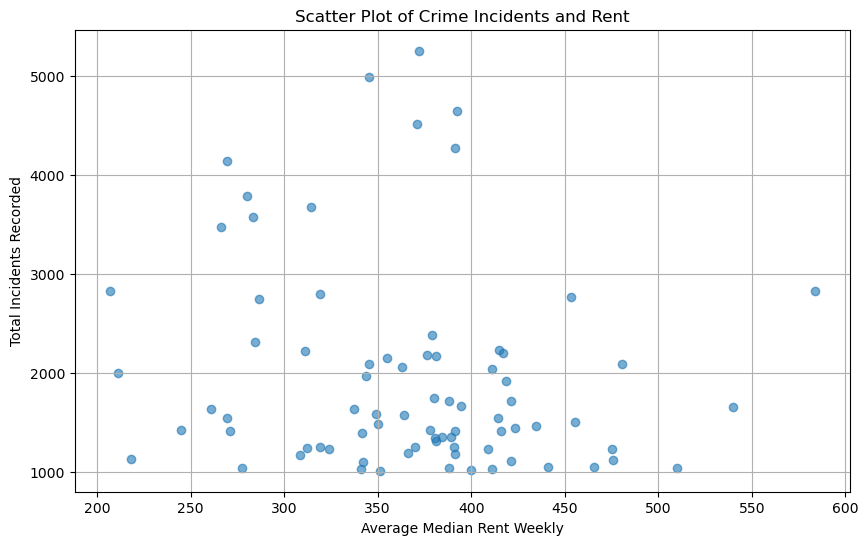

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Median_rent_weekly'], filtered_data['Incidents Recorded'], alpha=0.6)
plt.ylabel('Total Incidents Recorded')
plt.xlabel('Average Median Rent Weekly(AUD)')
plt.title('Scatter Plot of Crime Incidents and Rent')
plt.grid(True)
plt.show()

- The vertical axis indicates the total number of crime incidents recorded, ranging from around 1000 to just over 5000.
- The horizontal axis shows the average median weekly rent ranging from around 200 AUD to slightly above 550 AUD.
- The concentration of data points is more prominent in the rent range from about 250 AUD to 400 AUD, with varying numbers of crime incidents.
- Few data points appear at the higher rent values beyond 500 AUD, with relatively fewer crime incidents compared to the lower rent ranges.

##### 6.4.3.4.3 Moran’s I index and  Moran’s scatterplot

In [51]:
if not isinstance(filtered_data, gpd.GeoDataFrame):
    filtered_data = gpd.GeoDataFrame(filtered_data, geometry='geometry', crs=census_polygons.crs)  

Moran's I using KNN: 0.033851367952177865, p-value: 0.219


/Users/albert/anaconda3/envs/SDA/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.03', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.03)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

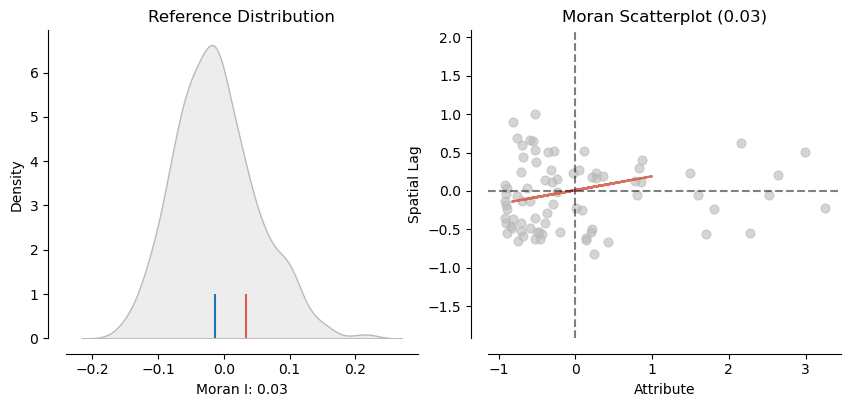

In [52]:
gdf = gpd.GeoDataFrame(filtered_data, geometry='geometry')

w_knn = KNN.from_dataframe(gdf, k=5)
w_knn.transform = 'r'

mi_knn = Moran(gdf['Incidents Recorded'], w_knn)
print(f"Moran's I using KNN: {mi_knn.I}, p-value: {mi_knn.p_sim}")

plot_moran(mi_knn)

### Incidents Recorded 

1. **Understanding Weak Spatial Autocorrelation in Incidents Recorded**:
   - **Moran's I Statistic for Incidents Recorded**:
     - **Index Value**: The calculated Moran's I index of 0.03 for "Incidents Recorded" demonstrates a very weak spatial autocorrelation, indicating that crime incidents are distributed almost randomly across the Greater Melbourne area.
     - **Reference Distribution and Scatterplot**: The reference distribution is nearly symmetrical around a low Moran's I value, suggesting almost no clustering. The Moran's I scatterplot visualizes minimal relationship between spatial lag and crime incidents, highlighted by a flat red trend line.
   - **Selected Point Analysis**: Analyzing a point near an attribute value of 1 and spatial lag of 0, located near the center of the scatterplot. This indicates a location with a low number of recorded incidents surrounded by areas with similarly low crime rates, suggesting a generally low-crime area.

##### 6.4.3.4.4 Spatial Data Analysis

In [ ]:
features = ['Incidents Recorded']
X = filtered_data[features].dropna().values  
X = sm.add_constant(X)  
y = filtered_data['Median_rent_weekly'].dropna().values

valid_indices = filtered_data[features].dropna().index.intersection(filtered_data['Median_rent_weekly'].dropna().index)
X = filtered_data.loc[valid_indices, features].values
X = sm.add_constant(X)  
y = filtered_data.loc[valid_indices, 'Median_rent_weekly'].values

knn_weights = KNN.from_dataframe(filtered_data.loc[valid_indices], k=4)

model = ML_Lag(y, X, knn_weights)
print(model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:          78
Mean dependent var  :    367.9171                Number of Variables   :           3
S.D. dependent var  :     72.0233                Degrees of Freedom    :          75
Pseudo R-squared    :      0.4918
Spatial Pseudo R-squared:  0.1237
Log likelihood      :   -423.2006
Sigma-square ML     :   2704.6762                Akaike info criterion :     852.401
S.E of regression   :     52.0065                Schwarz criterion     :     859.471

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

/Users/albert/anaconda3/envs/SDA/lib/python3.11/site-packages/spreg/ml_lag.py:634: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


###  Data Interpretation
- **Constant (CONSTANT)**: The model includes a constant term at 126.36689.
- **Incidents Recorded (var_1)**: The coefficient associated with the number of recorded incidents is -0.00687.
- **Spatial Lag of Dependent Variable (W_dep_var)**: The coefficient for the spatial lag of the dependent variable, which represents the influence of neighboring values on the median rent, is 0.17151.

## 7. Result

### 7.1 Scenario1 : Landmarks

**Method: Correlation between differnt landmark types and rent**
##### University Count vs. Rent (Correlation: 0.067)
- The plot for universities shows a very low correlation, with no significant upward trend in rents even where there are more universities.
- This could be due to the residential market around universities being influenced by various factors, such as generally lower-priced student accommodations, or a wider range of housing options in university areas affecting average rent levels.

##### Hospital Count vs. Rent (Correlation: 0.145)
- The scatter plot for hospitals shows rent fluctuations but no clear pattern indicating that more hospitals directly correlate with higher rents.
- The lower correlation might imply that hospitals' influence on rent is not as pronounced as transportation facilities, or that the impact of hospitals might be obscured by other geographical or socio-economic factors.

##### Station Count vs. Rent (Correlation: 0.256)
- The scatter plot indicates that a higher number of stations might be associated with higher rent levels. Particularly, areas with one station show a wide range of rents, but higher rents appear more concentrated.
- This suggests a significant positive impact of station presence on rent, which aligns with the common urban understanding that convenient public transport links enhance the attractiveness and value of residential areas.

**Method: Moran’s I index and  Moran’s scatterplot**

##### Median Rent Weekly
1. **Understanding Positive Spatial Autocorrelation in Median Rent Weekly**:
   - The positive Moran's I index suggests that regions with high median rents are typically surrounded by similarly high-rent areas, and likewise for low-rent regions. This pattern may reflect underlying economic conditions, zoning policies, or market forces that influence rent levels across neighborhoods.

2. **Implications of LISA Cluster Map Results for Urban Planning and Policy**:
   - **HH Clusters**: The presence of high-high clusters primarily in urban centers or affluent suburbs suggests these areas may benefit from strong economic activity, better amenities, and infrastructure. These regions could be targeted for premium housing developments or could be leveraged as prime locations for business investments.
   - **LL Clusters**: Low-low clusters often found on the outskirts or in less developed areas might highlight regions where economic interventions could stimulate growth, or where affordable housing policies could be most needed to support local populations.
   - **LH and HL Areas**: These anomalous clusters where rent levels significantly diverge from the surroundings might indicate transitional areas or zones undergoing significant changes. Such areas offer unique opportunities for urban renewal projects or targeted socio-economic programs.

3. **Strategic Insights for Real Estate and Municipal Planning**:
   - The spatial distribution of rent can guide policymakers in identifying which areas might benefit from revitalization efforts or where gentrification pressures might be mounting. 
   - Understanding the spatial patterns of rent can also help in forecasting future trends in real estate pricing, allowing for more strategic planning and better allocation of city resources.


##### University Count 

1. **Understanding Positive Spatial Autocorrelation in University Count**:
   - The positive Moran's I index of 0.16 suggests that regions with high university counts are typically surrounded by similarly high-university areas. This pattern might reflect underlying academic affiliations, proximity to major educational resources, or concentrated student populations.

2. **Implications of LISA Cluster Map Results for Urban Planning and Policy**:
   - **HH Clusters**: Areas with high-high clusters are likely located near major universities or college towns, benefiting from robust academic activities and associated economic benefits. These regions could be targeted for advanced educational facilities and student-oriented services.
   - **LL Clusters**: Low-low clusters typically found in areas far from major educational centers might indicate regions lacking higher education institutions. These areas might benefit from targeted educational investments to boost local development.
   - **LH and HL Areas**: Anomalous clusters where university counts significantly diverge from the surroundings could indicate either emerging educational zones or established areas facing shifts in educational demand. These areas provide unique opportunities for strategic urban and educational planning.

3. **Strategic Insights for Real Estate and Municipal Planning**:
   - **Geographic Distribution Analysis**: Understanding the spatial distribution of universities can help policymakers identify where to focus efforts on infrastructure development, public transport improvements, and housing to support academic communities.
   - **Forecasting and Resource Allocation**: Insights into where university counts are high or increasing can guide real estate developers and city planners in making informed decisions about where to allocate resources and develop properties that cater to students and faculty.


##### Hospital Count

1. **Understanding Weak Spatial Autocorrelation in Hospital Count**:
   - **The positive Moran's I index of 0.07**: Although indicating a positive spatial autocorrelation, it reflects a very weak level of clustering among areas with hospital counts, suggesting that the distribution of hospitals across Greater Melbourne is more random compared to other infrastructures like universities or stations.
   - **Reference Distribution and Scatterplot**: The broader and flatter peak of the reference distribution around the low Moran's I value suggests weak clustering or dispersion, aligning with the scatterplot's display of most points near the origin which indicates low spatial dependency among hospital locations.

2. **Implications of LISA Cluster Map Results for Urban Planning and Policy**:
   - **HH Clusters**: These clusters are likely concentrated around major healthcare facilities in Melbourne, such as those in the Parkville medical precinct, which includes several large hospitals. These are essential for healthcare delivery and typically well-connected by public transport, suggesting these areas could be targets for further healthcare investments.
   - **LL Clusters**: Often located in regions distant from Melbourne's center, where fewer medical facilities are available, potentially indicating either newer residential developments or rural settings. These areas could benefit from targeted healthcare infrastructure investments to improve service availability.
   - **LH and HL Clusters**: LH areas might be near significant medical precincts but with fewer facilities themselves, perhaps due to zoning restrictions or historical development patterns. HL clusters could represent specialized healthcare facilities or regional hospitals serving a broader area, suggesting potential areas for strategic healthcare resource optimization.

3. **Strategic Insights for Real Estate and Municipal Planning**:
   - **Geographic Distribution Analysis**: The weak spatial correlation in hospital distribution can guide policymakers in identifying which areas might require new hospital constructions or healthcare facility upgrades, ensuring equitable healthcare access.
   - **Forecasting and Resource Allocation**: Understanding where hospital counts are low and the population is underserved can help in prioritizing areas for healthcare investments, potentially leading to more strategic planning and better allocation of healthcare resources.


Thank you for sharing the format. Here's how the structured analysis for the station count could be formatted accordingly:

##### Station Count 

1. **Understanding Positive Spatial Autocorrelation in Station Count**:
   - The positive Moran's I index of 0.22 suggests that regions with high station counts are typically surrounded by similarly high-station areas. This pattern may reflect underlying strategic planning decisions, accessibility needs, or economic factors that drive public transportation infrastructure.

2. **Implications of LISA Cluster Map Results for Urban Planning and Policy**:
   - **HH Clusters**: The presence of high-high clusters primarily in urban centers or along major transit routes suggests these areas may benefit from strong transit connectivity, better amenities, and infrastructure. These regions could be leveraged as prime locations for further urban development and transit-oriented projects.
   - **LL Clusters**: Low-low clusters often found on the urban outskirts or in less developed areas might highlight regions where economic interventions could stimulate growth, or where transportation infrastructure investments could be most needed to support local populations.
   - **LH and HL Areas**: These anomalous clusters where station levels significantly diverge from the surroundings might indicate transitional areas or zones undergoing significant changes. Such areas offer unique opportunities for strategic urban and transit planning.

3. **Strategic Insights for Real Estate and Municipal Planning**:
   - The spatial distribution of stations can guide policymakers in identifying which areas might benefit from revitalization efforts or further development. Understanding the spatial patterns of station counts can also help in forecasting future trends in real estate pricing, allowing for more strategic planning and better allocation of city resources.

### Futher research

##### Key Factors Influencing High Rents in Rural or Peripheral Areas

1. **Scarcity and Exclusivity**:
   - In rural or scenic regions, the scarcity of available properties and the unique features of these properties (such as waterfront views or large land areas) can significantly drive up rental prices.

2. **Lifestyle Choices**:
   - With evolving work habits and lifestyle preferences, areas offering a superior quality of life, natural surroundings, or a reprieve from urban stress are increasingly valued, leading to higher rents.

3. **Tourism Impact**:
   - Proximity to tourist attractions can elevate rental prices due to the demand for short-term accommodations. This is particularly true for areas that offer unique recreational opportunities or natural beauty.

4. **Development Anticipation**:
   - In areas like Ravenhall, which are on the cusp of development, the anticipation of future urban amenities can lead to an early increase in rental prices as investors and renters speculate on the area's growth potential.

5. **Rural Premium**:
   - There is often a premium associated with the privacy, space, and tranquility that rural areas offer compared to more densely populated urban environments. This premium is reflected in higher rental prices as individuals pay more for these benefits.

**Method: Spatial Data Analysis**

### Analysis of Regression Outcomes

- **Impact of Proximity to Universities**: The negative coefficient for the distance to the nearest university (-0.0060) suggests that being closer to universities tends to be associated with slightly higher rents. This might reflect the demand for housing in areas that provide easy access to educational facilities, often preferred by students and academic staff.

- **Influence of Nearby Hospitals**: Conversely, being farther from hospitals correlates with a slight increase in rent (+0.0036). This counterintuitive result might indicate that areas further from hospital facilities are perhaps more residential or less busy, which can be a desirable trait for certain renters seeking quieter neighborhoods.

- **Proximity to Stations**: The positive coefficient for the distance to the nearest station (+0.0017) implies a very marginal increase in rent with increased distance from transport hubs. This could suggest a preference for less congested areas slightly removed from major transit routes, although the effect is minimal.

- **Spatial Dependency (W_dep_var)**: The strong positive spatial dependency (0.4339) underscores the significance of location and the collective attributes of an area in determining rent prices. This implies that rents are not just influenced by individual locational attributes but also by the broader spatial distribution of these features within the area.

**Government Recommendation**

1. **Strengthening University Districts**: The negative correlation between distance to universities and rent suggests that areas near universities have higher demand. Policy measures could include developing more student-friendly housing solutions, enhancing public amenities, and improving safety measures to make these areas more attractive and supportive for students and faculty.

2. **Healthcare Accessibility**: Although the proximity to hospitals showed a surprising trend with rents slightly increasing as distance increases, this could signal a preference for quieter, less congested residential areas. Governments could consider improving healthcare accessibility in suburban and rural areas to ensure equitable access without compromising the residential appeal of these areas.

3. **Transportation and Urban Development**: The finding that proximity to stations only slightly increases rent suggests an opportunity to develop transit-oriented developments (TODs) further from existing stations. This could help in managing urban sprawl and promoting the use of public transport through improved connectivity.

4. **Strategic Land Use Planning**: The significant spatial dependency observed indicates that rent prices are influenced by the broader area's characteristics rather than isolated features. This suggests a need for comprehensive planning that considers the cumulative effects of various infrastructure and amenities on housing costs. Strategic land use planning can help in balancing development across regions, preventing disproportionate rent increases in overly concentrated urban centers.

5. **Rural and Peripheral Development**: Considering the premium on rural and peripheral areas due to lifestyle changes and tourism, policies could focus on sustainable development in these areas. This includes preserving natural landscapes while providing modern amenities that can attract long-term residents and not just short-term visitors.

6. **Dynamic Housing Policies**: Given the varied influences of different landmarks and facilities on rental prices, dynamic and flexible housing policies that adapt to the changing demands and characteristics of different neighborhoods could be more effective. This could involve zoning adjustments, flexible housing regulations, and incentives for developers to invest in diverse types of housing projects.

### 7.2 Scenario2 : Landuse

**Method: Overlay Analysis of Land Cover Types and Median Rent**

The analysis showed that the average median rent for different land cover types within the study area varied slightly.

* Water areas had the highest average rent at A$391.18 per week.
* Cloud-covered areas had the lowest average rent at A$320.27 per week.
* Other land cover types, such as trees, crops, built-up areas, and pastures, had relatively similar average rents, indicating a flat distribution of rental values across these categories.

**Method: Weighted Overlay Analysis of Land Cover Types and Median Rent**

The weighted analysis revealed significant variations in the contribution of different land cover types to overall rent levels:

* Built Area: Contributed the most to the overall rent with a weighted average of A$131,979.90 per week. This high value is due to both the large size and high rent levels associated with built-up areas.
* Rangeland: Contributed significantly with a weighted average of A$32,766.08 per week, indicating its substantial presence and rent level in the study area.
* Trees: Also had a notable impact with a weighted average of A$31,488.70 per week, despite its larger proportion of land cover.
* Crops: Contributed A$22,719.41 per week, showing its considerable effect on overall rent.
* Water: Although having the highest unweighted average rent, its overall contribution was lower (A$2,000.39 per week) due to its smaller land cover proportion.
* Flooded Vegetation, Bare Ground, and Clouds: These had minimal impact on the overall rent, with weighted averages of A$349.65, A$181.99, and A$6.88 per week, respectively, indicating their limited presence and influence in the area.

Overall, the weighted analysis considers the actual percentage of area of each land cover type within the study area, making the results more reasonable and accurate. Built areas contribute significantly to overall rent levels because they are not only large in size but also have high rents. Tree-covered areas, despite their large size, have relatively low rents, indicating that they are mainly located in non-urbanised areas. Rangeland areas contribute significantly to rents, while flooded vegetation and cloud cover areas have a limited impact on overall rent levels.

**Method: Regression Analysis**

* Largest Positive Impact: Water covered areas had the largest positive impact on rents, increasing by $30.62.
* Minimal positive impact: Trees covered areas had the smallest positive impact on rents with an increase of $2.14.
* Most Negative Impact: Flooded Vegetation areas had the most negative impact on rents, decreasing by $44.89.
* Least Negative Impact: The Rangeland overlay area had the least negative impact on rents, decreasing by $0.78.

**Method: K-means cluster analysis**

Using K-means cluster analysis, we found a significant relationship between land cover type and rent level. The results show that different land cover types are associated with different rent levels.

* Cluster 0: Lowest rents, mainly consisting of Flooded Vegetation and Clouds.
* Cluster 1: Medium rents, primarily Bare Ground, Crops and Trees.
* Cluster 2: Highest rents, mainly Built Area, Water and Rangeland.

These results suggest that different land cover types influence rent levels to some extent.

**Government Recommendation**

- **Optimise land use**: The government should give priority to the development and optimisation of built-up areas as they have a significant positive impact on rents and can improve the overall economic performance.

- **Protecting and developing water areas**: Water covered areas have a significant positive impact on rents, and it is recommended that the government protect existing water areas and develop new water areas in urban planning to enhance overall rent levels.


- **Managing floodplain vegetation areas**: Floodplain vegetation areas have a significant negative impact on rents, and the government should consider strengthening the management of these areas to improve their utilisation and reduce the negative impact on overall rents.


- **Enhancing the value of non-urbanised areas**: For non-urbanised areas such as trees and pastures, the government should consider introducing infrastructure and services to increase the level of rents in these areas.

For Built Areas with higher rents, the government may consider increasing the supply of housing to balance the rent level.
For areas with lower rents (e.g. Flooded Vegetation and Clouds), infrastructure development can be strengthened to increase the region's attraction.

With these recommendations, the government can manage land use more effectively, improve overall economic efficiency, and achieve sustainable development goals.

### 7.3 Scenario3 : Crime

**Method: Correlation coefficient**

- **Implications of Pearson Correlation**: The low to moderate positive Pearson correlation may suggest that areas with slightly higher crime rates might also have higher rents, possibly due to being in urban centers where both crime and rent are elevated due to higher population density and property values.
- **Implications of Spearman Correlation**: The stronger Spearman correlation could indicate that when accounting for non-linear relationships and ranks, the association between crime rates and rent becomes clearer. This might reflect that as areas become more desirable (thus, higher rent), they also experience more recorded incidents, which could be related to higher foot traffic and economic activity in these areas. 

**Method: Scatter Plot**

**Scatter Plot Insights**:
   - The scatter plot shows that most areas have lower crime incidents, with a wide range of median weekly rents. A few outliers exist with very high incidents recorded but varying rent values.
   - This distribution might reflect that while crime rates and rent have some degree of association, other factors also significantly impact rent values, leading to the observed spread in the data.

#### Detailed Analysis for Postcode 3000

#### Background
- The postcode 3000 area is near educational institution(university of Melbourne), which likely supports higher rent levels due to demand from students and faculty staff.

#### Influencing Factors
- **High Demand**: The high demand for housing near educational facilities keeps rents high, even if crime rates increase.
- **Type of Crime**: The crimes near schools may predominantly be non-violent (such as theft, property damage), which have a minimal direct impact on rent prices.
- **Geographical Advantage**: The vicinity to schools typically offers better location and convenience, which supports rent prices even if crime rates are higher.

####  Conclusion
Overall, there is a certain positive correlation between crime incidents and rent prices, but it is relatively weak. Considering the specific characteristics of postcode 3000 (near schools), we can see that even with higher crime rates, rents remain relatively high. This is mainly due to the high demand for housing from students and faculty staff and the geographical advantages of areas near schools.

#### Further Search(choose Incidents Recorded from 1000 to 6000)

**Method: Scatter Plot**

**Scatter Plot Insights**:
- It can be observed from the figure that as the weekly rent increases, the number of crime records tends to decrease. This indicates that in areas with higher rents, the crime rate is lower, which may be related to the fact that high-rent areas usually have better security facilities, higher living standards and lower socioeconomic pressures.

**Method: Moran’s I index and  Moran’s scatterplot**

### Incidents Recorded

1. **Understanding Weak Spatial Autocorrelation in Incidents Recorded**:
   - The very low Moran's I index of 0.03 indicates almost no spatial autocorrelation among the recorded incidents, suggesting that crime incidents are distributed nearly randomly across the Greater Melbourne area.

2. **Strategic Insights for Urban Safety and Law Enforcement**:
   - **Resource Allocation**: The weak autocorrelation suggests that crime does not cluster significantly in specific neighborhoods, which might imply that resource allocation for law enforcement and community safety initiatives should be evenly distributed across the city, rather than concentrated in certain areas.
   - **Preventative Measures**: Policymakers might consider developing broad-based community engagement strategies that address factors contributing to crime across various demographics and locations.
   - **Urban Development**: Understanding the random distribution can help city planners ensure that new developments incorporate design features that enhance safety, such as better lighting and more public spaces that are easily surveillable, to prevent crime in areas currently showing lower incidents.

These insights focus on policy and planning implications derived directly from the spatial analysis of crime incident data, aligning with the provided Moran's I results.

**Method: Spatial Data Analysis**

**Analysis of Regression Outcomes**
- **Distance to the nearest university (var_1)**: The negative coefficient suggests a decrease in rent as the distance to universities increases, indicating that proximity to universities might increase rental values.
- **Spatial Influence (W_dep_var)**: The positive coefficient implies that areas surrounded by higher rent zones also tend to have higher rents, highlighting a pattern of spatial dependency in rental pricing.

**Government Recommendation**

1. **Enhanced Safety Measures in Urban Centers**: Given the observed correlation between crime rates and higher rents in urban areas, it is advisable for local governments to increase safety measures. This could include enhanced street lighting, increased police patrols, and community safety programs, especially in densely populated or high-foot-traffic areas.

2. **Targeted Law Enforcement**: The weak spatial autocorrelation of crime incidents suggests that crime does not concentrate in specific areas but is rather distributed across the city. Law enforcement resources should therefore be strategically allocated across a wider area rather than focusing intensively on perceived high-crime neighborhoods.

3. **Crime Prevention through Environmental Design (CPTED)**: Implement urban planning strategies that focus on crime prevention through design features that increase the natural surveillance of public spaces, control access points, and foster territorial reinforcement through community engagement.

## 8. Methodological Approaches: Advantages, Disadvantages, and Limitations

### Scatter Plot

#### Advantages:
- **Intuitive Visualization**: Scatter plots visually display the relationship between two variables, making it easy to identify patterns, trends, and outliers.
- **Simplicity**: They are straightforward to understand and interpret, suitable for presenting simple two-dimensional data relationships.
- **Flexibility**: Trend lines or regression lines can be overlaid on scatter plots to further analyze relationships between variables.

#### Disadvantages:
- **Dimensional Limitation**: They can only show the relationship between two variables, making it challenging to handle high-dimensional data.
- **Limited Information**: With a large number of data points, the plot can become cluttered, making it difficult to extract meaningful insights.

### Bar Chart

#### Advantages:
- **Ease of Comparison**: Bar charts are ideal for comparing values across different categories or groups, clearly showing data distribution and differences.
- **Versatility**: They can display single or multiple categories of data, suitable for showing frequency distributions, totals, and percentages.

#### Disadvantages:
- **Dimensional Limitation**: Typically, bar charts can only display one dimension of data.
- **Increased Complexity**: For multiple categories or stacked bar charts, the plot can become complex and harder to interpret.

### Moran's I

#### Advantages:
- **Spatial Autocorrelation**: Moran's I is a classic measure for detecting spatial autocorrelation, quantitatively assessing the clustering or dispersion of geographic data.
- **Significance Testing**: It allows for significance testing to determine whether spatial autocorrelation is statistically significant.

#### Disadvantages:
- **Computational Complexity**: Requires the calculation of adjacency and weight matrices, which can be computationally intensive.
- **Dependency on Adjacency Definition**: Results can depend on how the adjacency matrix is defined, with different definitions potentially leading to different outcomes.

### Moran Scatter Plot

#### Advantages:
- **Intuitive Display**: Moran scatter plots visually represent Moran's I value and its spatial distribution, aiding in identifying spatial clustering patterns.
- **Spatial Relationship Visualization**: Graphically shows spatial relationships and autocorrelation, making it easier to understand and interpret.

#### Disadvantages:
- **Complexity**: Can be difficult to understand and interpret for non-specialists.
- **Data Requirements**: Requires robust geographic spatial data, with data quality significantly impacting results.

### Spatial Data Analysis

#### Advantages:
- **Spatial Pattern Recognition**: Identifies and interprets spatial patterns and trends in geographic phenomena, helping understand geographic distribution laws.
- **Multidimensional Analysis**: Combines multiple spatial variables for complex spatial statistics and modeling.
- **Decision Support**: Provides powerful decision support tools for urban planning, environmental management, public health, and other fields.

#### Disadvantages:
- **High Data Requirements**: Requires high-quality spatial data, which can be costly to collect and process.
- **Technical Complexity**: Involves complex statistical and GIS (Geographic Information Systems) techniques, requiring a high level of technical expertise.
- **Interpretation Difficulty**: Results interpretation can be challenging, requiring professional knowledge and experience.

### Unweighted Analysis of Land Cover Types and Median Rent

#### Advantages

- **Simple and easy to use**: Calculating the average rent for different land cover types is relatively simple and is suitable for preliminary analyses.
- **Direct Comparison**: The ability to directly compare the rent levels of different land cover types is easy to understand and interpret.

#### Disadvantages

- **Ignores weighting**: Does not take into account the proportion of the actual area of each land cover type within the study area. As a result, the conclusions derived may not be accurate, because some land cover types may occupy a large area within the study area, while others are relatively small.
- **Does not apply to complex situations**: Cannot reveal the relationship between more complex land cover types and rents.

#### Limitations

- **Data balance**: Does not reflect the extent to which actual land cover type affects rents because it is not weighted.

### Weighted Analysis of Land Cover Types and Median Rent

#### Advantages

- **More Reasonable**: Considers the proportion of different land cover types within the study area, making the results more aligned with the actual situation.
- **High Accuracy**: More accurately reflects the contribution of each land cover type to overall rent levels.

#### Disadvantages

- **Complexity**: The calculation process is more complex and requires additional data processing steps.
- **Dependence on Area**: High accuracy requirements for the area of each region, which may be affected by data quality.

#### Limitations
Cannot reflect the dynamic changes in land use and rent levels, providing only a static analysis result.

### OLS Regression Analysis

#### Advantages

- **Quantitative Analysis**: Regression analyses quantify the impact of different land cover types on rents, which helps to understand the impact of land use on the property market.
The results clearly indicate which land cover types have a significant impact on rents, providing data support for urban planning and policy development.
- **Multivariable Analysis**: Can simultaneously analyze the impact of multiple variables, suitable for complex situations.

#### Disadvantages

- **Linear Assumption**: Assumes a linear relationship between land cover types and rent, which may not reflect the actual situation.
- **Multicollinearity**: There may be multicollinearity issues between multiple variables, affecting the accuracy of the results.

The limited time span of the data may not reflect long-term trends.
Uneven distribution of land cover types may result in amplification or minimisation of the impact of certain types.

#### Limitations

The R-squared and Adj. R-squared are both 0.009, indicating that the model explains about 0.9 per cent of the total variation. This indicates that land cover type has a small effect on rent and the model has limited explanatory power. The variation in rent is therefore also determined by other factors not included in the model.

### K-means Clustering Analysis

#### Advantages

- **Pattern Recognition**: Can identify patterns and clusters in the data, recognizing areas with similar rent levels.
- **Unsupervised Learning**: Does not require pre-set labels, suitable for exploratory data analysis.

#### Disadvantages

- **Parameter Dependence**: The choice of the number of clusters (k value) has a significant impact on the results, requiring multiple experiments to determine the optimal value.

#### Limitations

Does not consider the continuity and geographical proximity of spatial data, which may affect the practical application of the results.

#### Overal Limitations

- **Data Quality**: Spatial data analysis heavily relies on data accuracy and completeness; poor quality data can lead to misleading results.
- **Scale Effect**: Analysis results can be influenced by spatial scale, with different scales potentially yielding different results.
- **Assumption Dependence**: Many spatial analysis methods rely on specific assumptions, and if these assumptions are not met, the reliability of the results may be compromised.
- **Computational Resources**: Complex spatial analyses often require significant computational resources, especially when handling large-scale data.

## 9.Conclusion

In conclusion, this study exposes multiple influences on rental prices in Melbourne by analysing three key aspects: landmark distribution, land use patterns, and crime rates, and then using a variety of analytical methods to reveal how these factors work together to influence the dynamics of the city's rental market.

In the landmark analysis, stations have the most significant impact on rents, followed by hospitals and universities. This suggests that accessibility to public transport plays important role in increasing rent levels. In addition, there is some positive correlation between crime rates and rents, but their impact is weak. This may reflect the phenomenon higher rent areas record more crime incidents due to higher population density and economic activity.

The analysis of land use patterns shows significant differences in the impact of different land cover types on rents. Built-up areas and watersheds had a significant positive impact on rents, while flooded vegetation had a negative impact. These effects were further confirmed through weighted average and regression analyses, which points to the role of different land use types in increasing or decreasing rents.

The findings of this study provide valuable reference information for urban planners, policy makers and real estate professionals to better understand the drivers of rental prices. This can help them to formulate more effective urban development, housing policies and investment strategies for sustainable urban development.

## 10.reference

1. Ogur, J. D. (1973). Higher education and housing: The impact of colleges and universities on local rental housing markets. *The American Journal of Economics and Sociology*, 32(4), 387-394.

2. Saberi, M., Wu, H., Amoh-Gyimah, R., Smith, J., & Arunachalam, D. (2017). Measuring housing and transportation affordability: A case study of Melbourne, Australia. *Journal of Transport Geography*, 65, 134-146.

3. Zhang, P. (2020). Regression analysis of factors affecting urban housing rent and spatial econometric analysis—Based on the GWR model of Beijing's rent data. *Urban Problems*, 5, 45-48.

4. Alonso, W. (1964). *Location and land use: Toward a general theory of land rent*. Harvard University Press. https://doi.org/10.4159/harvard.9780674730854

5. Buonanno, P., Montolio, D., & Raya-Vílchez, J. M. (2013). Housing prices and crime perception. *Empirical Economics*, 45(2), 305-321.